# Projektarbeit Data Analytics
## von Catharina-Emilia Ahrens und Juliana Kühn

Gliederung der Projektarbeit:

1. [Datenvorbereitung, Semistrukturierte Daten](#Aufgabe-1)  

2. [Explorative Datenanalyse](#Aufgabe-2)  

3. [Interaktive Karte](#Aufgabe-3)  

4. [Weitere Analyse von Stammdaten](#Aufgabe-4)  

5. [Akquise und Analyse von Wetterdaten](#Aufgabe-5)  

6. [Abschätzung des Ertrags von Windkraftanlagen, Standortplanung](#Aufgabe-6)  

7. [Zusammenfassung und Erkenntnisse](#Zusammenfassung-und-Erkenntnisse)  

8. [Quellenverzeichnis](#Quellenverzeichnis)  



#### Importieren der benötigten Bibliotheken

In [1]:
import glob
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import requests 
import json
from geopy.distance import geodesic
import seaborn as sns 
import plotly.graph_objects as go 
import plotly.express as px
import dash
from dash import Dash, dcc, html 
import warnings
import datetime
from IPython.display import Markdown

warnings.filterwarnings("ignore", category=FutureWarning)

# Aufgabe 1
### __Datenvorbereitung, Semistrukturierte Daten__

__a) HTML Files auslesen, zu einem DataFrame zusammenfügen, binäres Flag erstellen__

Erstellen eines binären Flags zum Steuern, ob beim Ausführen des Notebooks der Dataframe **df_anlagen** durch Auslesen der HTML-Dokumente neu erzeugt wird, oder ob er direkt aus der CSV-Datei eingelesen wird:

In [2]:
df_from_htmlfiles = False

Zugriff und Extrahieren der HTML Dateien und Zusammenfügen zu einem Dataframe:

In [3]:
folder_path = r"C:\Users\Julia\OneDrive\Dokumente\OTH Studium\Data Analytics\Anlagendaten"

Mit der glob Funktion werden alle Dateien, die auf .html enden gefunden und in der Variable html_files
abgespeichert, um diese später wieder verwenden zu können, zudem wird eine Liste **dataframes** erstellt, damit die Daten für jede Windkraftanlage dort erstmal gespeichert werden:

In [4]:
html_files = glob.glob(folder_path + "/*.html")
dataframes = []

Nun werden mittels einer **for-schleife** die HTML-Dateien ausgelesen, sie werden nacheinander geöffnet mit der Funktion **with open()** und anschließend mit der Funktion **read** ausgelesen

Anschließend wird mithilfe des Paketes **BeautifulSoup** der Inhalt der jeweiligen HTML-Datei analysiert und in der Variable **soup** gespeichert.

Danach werden mit der Variable soup die erforderlichen Daten rausgesucht:
man erstellt eine Variable mit z.B. mast_nr_element, die die MaStR-Nummer der Einheit speichern soll. Nach dieser Nummer wird in der Variable soup im HTML-Tag **td**, welche die Klasse **display-template-value** und den Titel **MaStR-Nummer der Einheit** enthält, gesucht. Wenn die Nummer gefunden wird, wird sie als String mithilfe von **text.strip()** in der Variable **mast-nr** gespeichert. So werden alle benötigten Daten rausextrahiert, die wir vorher in der HTML-Datei im Seitenquelltext nachgeschaut haben.

Danach werden die Daten, die in den Variablen gespeichert sind, im Dataframe **df** hinzugefügt mit jeweiliger Angabe der Spaltennamen und den Inhalt von der Spalte, z.B.: "Name Stromerzeugungseinheit MaStR": [name]

Zum Schluss werden alle Dataframes zu einem Dataframe kombiniert und dann auch in eine CSV-Datei gespeichert, damit man mit dem Flag auch darauf zugreifen kann:

In [5]:
if df_from_htmlfiles:

    for file_path in html_files:
        with open(file_path, "r") as file:
            html_content = file.read()

        soup = BeautifulSoup(html_content, "html.parser")

        mast_nr_element = soup.find("td", class_="display-template-value", title="MaStR-Nummer der Einheit")
        mast_nr = mast_nr_element.text.strip() if mast_nr_element else ""

        name_element = soup.find("td", class_="display-template-value", title="Anzeige-Name der Stromerzeugungseinheit im MaStR")
        name = name_element.text.strip() if name_element else ""

        windpark = soup.find("td", class_="display-template-value", title="Anzeige-Name des Windparks im MaStR")
        wp = windpark.text.strip() if windpark else ""

        breitengrad = soup.find("td", class_="display-template-value", title="Breitengrad")
        bg = breitengrad.text.strip() if breitengrad else ""

        laengengrad = soup.find("td", class_="display-template-value", title="LÃ¤ngengrad")
        lg = laengengrad.text.strip() if laengengrad else ""

        inbetriebnahme = soup.find("td", class_="display-template-value", title="Datum der erstmaligen Inbetriebnahme der EEG-Anlage")
        inbetr = inbetriebnahme.text.strip() if inbetriebnahme else ""

        netto = soup.find("td", class_="display-template-value", title="Nettonennleistung")
        nn = netto.text.strip() if netto else ""

        betriebsstatus = soup.find("td", class_="display-template-value", title="Betriebsstatus")
        bs = betriebsstatus.text.strip() if betriebsstatus else ""

        installiert = soup.find("td", class_="display-template-value", title="Installierte Leistung der EEG-Anlage")
        install = installiert.text.strip() if installiert else ""

        voll_teil = soup.find("td", class_="display-template-value", title="Volleinspeisung oder Teileinspeisung?")
        vt = voll_teil.text.strip() if voll_teil else ""

        betreiber = soup.find("td", class_="display-template-value", title="Anlagenbetreiber der Einheit")
        betreib = betreiber.text.strip() if betreiber else ""

        hersteller = soup.find("td", class_="display-template-value", title="Hersteller der Windenergieanlage")
        herst = hersteller.text.strip() if hersteller else ""

        typenbezeichnung = soup.find("td", class_="display-template-value", title="Typenbezeichnung")
        tb = typenbezeichnung.text.strip() if typenbezeichnung else ""

        nabenhoehe = soup.find("td", class_="display-template-value", title="NabenhÃ¶he")
        nh = nabenhoehe.text.strip() if nabenhoehe else ""

        rotordurchmesser = soup.find("td", class_="display-template-value", title="Rotordurchmesser")
        rd = rotordurchmesser.text.strip() if rotordurchmesser else ""

        genehmigungsdatum = soup.find("td", class_="display-template-value", title="Genehmigungsdatum")
        gd = genehmigungsdatum.text.strip() if genehmigungsdatum else ""
        
        geplantBetrieb = soup.find("td", class_="display-template-value", title="Geplantes Inbetriebnahmedatum")
        pB = geplantBetrieb.text.strip() if geplantBetrieb else ""

        standort = soup.find("div", class_="col-xs-11", div="")
        ort = standort.text.strip() if standort else ""

        df = pd.DataFrame({"Name Stromerzeugungseinheit MaStR": [name], "Name Windpark": [wp],
                           "MaStR-Nummer der Einheit": [mast_nr], "Anlagenbetreiber": [betreib],
                           "Betriebsstatus": [bs], "Datum erst. Inbetriebnahme": [inbetr], 
                           "Geplantes Inbetriebnahmedatum": [pB],
                           "Standort": [ort], "Breitengrad": [bg], "Längengrad": [lg],
                           "Nettonennleistung": [nn], "Nabenhöhe": [nh], "Rotordurchmesser": [rd],
                           "Hersteller": [herst], "Typenbezeichnung": [tb], "Voll-/Teileinspeisung": [vt],
                           "Genehmigungsdatum": [gd], "Installierte Leistung": [install]})
        dataframes.append(df)

    df_anlagen = pd.concat(dataframes, ignore_index=True)
    df_anlagen.to_csv('anlagendaten.csv', encoding='utf-8', index=False) #ohne index
else:
    df_anlagen = pd.read_csv("anlagendaten.csv")


Ausgabe des Dataframes, um sich einen Überblick zu verschaffen wie es aussieht:

In [6]:
df_anlagen 

,Name Stromerzeugungseinheit MaStR,Name Windpark,MaStR-Nummer der Einheit,Anlagenbetreiber,Betriebsstatus,Datum erst. Inbetriebnahme,Geplantes Inbetriebnahmedatum,Standort,Breitengrad,Längengrad,Nettonennleistung,Nabenhöhe,Rotordurchmesser,Hersteller,Typenbezeichnung,Voll-/Teileinspeisung,Genehmigungsdatum,Installierte Leistung
0,WEA 1,Windpark Neuhof,SEE975973981666,BÃ¼rgerwindenergie Neuhof GmbH ï¼† Co. KGBÃ¼rg...,In Betrieb,18.10.2016,NaN,90616 Neuhof\nDeutschland,"49,432306 Â° N","10,660917 Â° O",3.300 kW,137 m,126 m,Vestas Deutschland GmbH,V-126 3.3 MW,Volleinspeisung,24.03.2016,3.300 kW
1,V-205778,Windpark Hopferstadt,SEE990997372290,Windpark Hopferstadt GmbH ï¼† Co. KGWindpark H...,In Betrieb,10.12.2014,NaN,97199 Ochsenfurt\nDeutschland,"49,6057 Â° N","10,033514 Â° O",2.000 kW,125 m,90 m,Vestas Deutschland GmbH,V90,Volleinspeisung,26.03.2014,2.000 kW
2,Aufwind,Aufwind,SEE978971279582,ABR979616894788 (natÃ¼rliche Person),EndgÃ¼ltig stillgelegt,01.10.1996,NaN,93183 KallmÃ¼nz\nDeutschland,49 Â° N,12 Â° O,100 kW,38 m,21 m,FuhrlÃ¤nder AG,FL 100,Volleinspeisung,NaN,0 kW
3,V-205779,Windpark Hopferstadt,SEE966429713405,Windpark Hopferstadt GmbH ï¼† Co. KGWindpark H...,In Betrieb,10.12.2014,NaN,97199 Ochsenfurt\nDeutschland,"49,602821 Â° N","10,041377 Â° O",2.000 kW,125 m,90 m,Vestas Deutschland GmbH,V90,Volleinspeisung,26.03.2014,2.000 kW
4,V - 41335,Windpark Bolzhausen,SEE924957666754,Windpark Bolzhausen GmbH ï¼† Co. KGWindpark Bo...,In Betrieb,30.03.2011,NaN,97255 Sonderhofen\nDeutschland,"49,60042 Â° N","10,041837 Â° O",2.000 kW,105 m,90 m,Vestas Deutschland GmbH,V90,Volleinspeisung,24.06.2010,2.000 kW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,KWA Gb R52 - 1,KWA Gb R52,SEE982313209625,ABR959577289175 (natÃ¼rliche Person),In Planung,NaN,21.04.2023,90768 FÃ¼rth\nDeutschland,-,-,1 kW,10 m,"1,5 m",SkyWind GmbH,SkyWind NG,Teileinspeisung (einschlieÃŸlich Eigenverbrauch),NaN,NaN
1347,Wind_Altorf,-,SEE921847267718,PfÃ¤ffingerPfÃ¤ffinger,In Planung,NaN,20.04.2023,84032 Altdorf\nDeutschland,-,-,2 kW,8 m,"1,5 m",SkyWind GmbH,2x SkyWind NG 1kW,Teileinspeisung (einschlieÃŸlich Eigenverbrauch),NaN,NaN
1348,WohngebÃ¤ude,WohngebÃ¤ude,SEE950880848370,ABR930619370198 (natÃ¼rliche Person),In Betrieb,27.03.2023,NaN,91781 WeiÃŸenburg\nDeutschland,-,-,1 kW,NaN,"1,5 m",SkyWind GmbH,SkyWind NG,Teileinspeisung (einschlieÃŸlich Eigenverbrauch),NaN,1 kW
1349,Skywind,Skywind,SEE967578323439,ABR921174412201 (natÃ¼rliche Person),In Betrieb,01.01.2023,NaN,86470 Thannhausen\nDeutschland,-,-,"0,8 kW",NaN,"1,5 m",SkyWind GmbH,SkyWind NG,Teileinspeisung (einschlieÃŸlich Eigenverbrauch),NaN,"0,8 kW"


__b) Geo-Positionsdaten in ein numerisches Format (float) überführen:__  

Um die Geo-Positionsdaten (Längengrad und Breitengrad) in ein numerisches Format (float) zu überführen, müssen wir die Spalten erst einmal bearbeiten. Da die Werte in einem String gespeichert sind, müssen wir diesen erst splitten um nur die Zahlenwerte zu erhalten. Zudem müssen bestimmte Zeichen wie "," oder "-" aus dem Zahlenwert entfernen um eine korrekte Float-Überführung durchführen zu können. Fehlende Werte in der Spalte werden mit np.nan, wie in der Angabe erwünscht, ersetzt. Zum Schluss prüfen wir dann mit der **dtypes** Methode ob die Spalten nun wirklich den Typ float haben:

In [7]:
df_anlagen['Breitengrad'] = df_anlagen['Breitengrad'].str.split(' ').str[0]
df_anlagen['Längengrad'] = df_anlagen['Längengrad'].str.split(' ').str[0]

In [8]:
df_anlagen['Breitengrad'] = df_anlagen['Breitengrad'].str.replace(",",".").str.replace("-","").str.replace(" ","")
df_anlagen['Längengrad'] = df_anlagen['Längengrad'].str.replace(",",".").str.replace("-","").str.replace(" ","")

In [9]:
df_anlagen['Breitengrad'] = df_anlagen['Breitengrad'].fillna(np.nan)
df_anlagen['Längengrad'] = df_anlagen['Längengrad'].fillna(np.nan)

In [10]:
df_anlagen['Breitengrad']  = pd.to_numeric(df_anlagen["Breitengrad"], downcast="float")
df_anlagen['Längengrad']  = pd.to_numeric(df_anlagen["Längengrad"], downcast="float")
print(df_anlagen.dtypes)

Name Stromerzeugungseinheit MaStR     object
Name Windpark                         object
MaStR-Nummer der Einheit              object
Anlagenbetreiber                      object
Betriebsstatus                        object
Datum erst. Inbetriebnahme            object
Geplantes Inbetriebnahmedatum         object
Standort                              object
Breitengrad                          float32
Längengrad                           float32
Nettonennleistung                     object
Nabenhöhe                             object
Rotordurchmesser                      object
Hersteller                            object
Typenbezeichnung                      object
Voll-/Teileinspeisung                 object
Genehmigungsdatum                     object
Installierte Leistung                 object
dtype: object


**c) Datensatz auf fehlende Werte überprüfen, Füllgrad der einzelnen Spalten ermitteln** 

Hier wird als erstes überprüft, in welchen Spalten es wieviele fehlenden Werte gibt:

In [11]:
df_anlagen.isnull().sum()

Name Stromerzeugungseinheit MaStR       0
Name Windpark                           0
MaStR-Nummer der Einheit                0
Anlagenbetreiber                        0
Betriebsstatus                          0
Datum erst. Inbetriebnahme             32
Geplantes Inbetriebnahmedatum        1319
Standort                                0
Breitengrad                           179
Längengrad                            179
Nettonennleistung                       0
Nabenhöhe                              36
Rotordurchmesser                        0
Hersteller                              0
Typenbezeichnung                        0
Voll-/Teileinspeisung                   0
Genehmigungsdatum                     439
Installierte Leistung                  32
dtype: int64

Anschließend wird der Füllgrad für jede einzelne Spalte berechnet.  
Wir beginnen mit der Spalte **Datum erstmalige Inbetriebnahme"**:

In [12]:
anzahl_nan = df_anlagen["Datum erst. Inbetriebnahme"].isnull().sum()
anzahl_zeilen = df_anlagen["Datum erst. Inbetriebnahme"].count()

fuellgrad = (anzahl_zeilen - anzahl_nan) / anzahl_zeilen * 100
fuellgrad

97.57391963608795

Füllgrad für Spalte **Breitengrad**:

In [13]:
anzahl_nan = df_anlagen["Breitengrad"].isnull().sum()
anzahl_zeilen = df_anlagen["Breitengrad"].count()

fuellgrad = (anzahl_zeilen - anzahl_nan) / anzahl_zeilen * 100
fuellgrad

84.72696245733789

Füllgrad für Spalte **Längengrad**:

In [14]:
anzahl_nan = df_anlagen["Längengrad"].isnull().sum()
anzahl_zeilen = df_anlagen["Längengrad"].count()

fuellgrad = (anzahl_zeilen - anzahl_nan) / anzahl_zeilen * 100
fuellgrad

84.72696245733789

Füllgrad für Spalte **Nabenhöhe**:

In [15]:
anzahl_nan = df_anlagen["Nabenhöhe"].isnull().sum()
anzahl_zeilen = df_anlagen["Nabenhöhe"].count()

fuellgrad = (anzahl_zeilen - anzahl_nan) / anzahl_zeilen * 100
fuellgrad

97.26235741444867

Füllgrad für Spalte **Genehmigungsdatum**:

In [16]:
anzahl_nan = df_anlagen["Genehmigungsdatum"].isnull().sum()
anzahl_zeilen = df_anlagen["Genehmigungsdatum"].count()

fuellgrad = (anzahl_zeilen - anzahl_nan) / anzahl_zeilen * 100
fuellgrad

51.864035087719294

Füllgrad für Spalte **Installierte Leistung**:

In [17]:
anzahl_nan = df_anlagen["Installierte Leistung"].isnull().sum()
anzahl_zeilen = df_anlagen["Installierte Leistung"].count()

fuellgrad = (anzahl_zeilen - anzahl_nan) / anzahl_zeilen * 100
fuellgrad

97.57391963608795

Bei der Spalte **erstmaligen Inbetriebnahme**, dachten wir, dass wir die fehlenden Werte durch die Werte der Spalte "geplantes Inbetriebnahmedatum" ersetzen, da diese Werte auch theoretisch als erstmalige Inbetriebnahme gelten:

In [18]:
df_anlagen.loc[df_anlagen["Datum erst. Inbetriebnahme"].isna(), "Datum erst. Inbetriebnahme"] = df_anlagen["Geplantes Inbetriebnahmedatum"]

__d) Geeignete Transformationen auf alle anderen Spalten vorbereiten__  

Im Dataframe hat man gesehen, dass die Umlaute nicht richtig angezeigt wurden. Deshalb konvertieren die kodierten Umlaute in die richtige Form:

In [19]:
df_anlagen['Name Windpark'] = df_anlagen['Name Windpark'].str.replace("Ã¼","ü").str.replace("Ã¶","ö").str.replace("Ã¤","ä").str.replace("ï¼†","&").str.replace("ÃŸ","ß")
df_anlagen['Name Stromerzeugungseinheit MaStR'] = df_anlagen['Name Stromerzeugungseinheit MaStR'].str.replace("Ã¼","ü").str.replace("Ã¶","ö").str.replace("Ã¤","ä").str.replace("ï¼†","&").str.replace("ÃŸ","ß")
df_anlagen['Anlagenbetreiber'] = df_anlagen['Anlagenbetreiber'].str.replace("Ã¼","ü").str.replace("Ã¶","ö").str.replace("Ã¤","ä").str.replace("ï¼†","&").str.replace("ÃŸ","ß")
df_anlagen['Betriebsstatus'] = df_anlagen['Betriebsstatus'].str.replace("Ã¼","ü").str.replace("Ã¶","ö").str.replace("Ã¤","ä")
df_anlagen['Standort'] = df_anlagen['Standort'].str.replace("Ã¼","ü").str.replace("Ã¶","ö").str.replace("Ã¤","ä").str.replace("ÃŸ","ß")
df_anlagen['Hersteller'] = df_anlagen['Hersteller'].str.replace("Ã¼","ü").str.replace("Ã¶","ö").str.replace("Ã¤","ä").str.replace("ÃŸ","ß")
df_anlagen['Voll-/Teileinspeisung'] = df_anlagen['Voll-/Teileinspeisung'].str.replace("Ã¼","ü").str.replace("Ã¶","ö").str.replace("Ã¤","ä").str.replace("ÃŸ","ß")

Da in der Spalte Standort, der Ort und die Postleitzahl gemeinsam in einem String gespeichert sind, splitten wir auch diesen String, um den Ortsnamen in "Standort" zu speichern und um die Postleitzahl in eine extra Spalte zu extrahieren:

In [20]:
df_anlagen['Standort'] = df_anlagen['Standort'].str.split('\n').str[0]

In [21]:
pattern = r"(\b\w+\b)(?=.*\b\1\b)"

In [22]:
df_anlagen['Anlagenbetreiber'] = df_anlagen['Anlagenbetreiber'].str.replace("KG", "KG-").str.replace("GbR", "GbR-")
df_anlagen['Anlagenbetreiber'] = df_anlagen['Anlagenbetreiber'].str.split('-').str[0]
df_anlagen['Anlagenbetreiber'] = df_anlagen['Anlagenbetreiber'].str.split(pattern).str[0]
df_anlagen['Anlagenbetreiber'].value_counts().head()

Breeze Two Energy GmbH & Co. KG    28
                                   21
Windpark Notos GmbH & Co. KG       16
VR                                 13
Stadtwerke                         13
Name: Anlagenbetreiber, dtype: int64

In [23]:
df_anlagen = df_anlagen.drop('Geplantes Inbetriebnahmedatum', axis=1)

Um die Postleitzahlen in einer Spalte speichern zu können, müssen wir diese mithilfe von Regex rausextrahieren aus der Standortspalte. Die Zahlenwerte werden übergangsweise in der Spalte "Postleitzahl_temp" gespeichert:

In [24]:
df_anlagen['Postleitzahl_temp'] = df_anlagen['Standort'].str.extract(r'(\d{5})')

Die Spalte Standort soll jetzt nur noch die Ortsnamen selber beinhalten, deshalb löschen wir die Postleitzahlen raus:

In [25]:
df_anlagen['Standort'] = df_anlagen['Standort'].str.replace("(\d{5})", "")

Die Spalte Postleitzahlen soll nun an siebter Stelle vor der Spalte Standort eingefügt werden:

In [26]:
idx = 6
df_anlagen.insert(loc=idx, column='Postleitzahl', value=df_anlagen['Postleitzahl_temp'])

Die temporäre Spalte mit den Postleitzahlen wird nun wieder gelöscht:

In [27]:
df_anlagen = df_anlagen.drop('Postleitzahl_temp', axis=1)

Kurze Überprüfung, wie das Dataframe df_anlagen nun ausschaut:

In [28]:
df_anlagen.tail(50)

,Name Stromerzeugungseinheit MaStR,Name Windpark,MaStR-Nummer der Einheit,Anlagenbetreiber,Betriebsstatus,Datum erst. Inbetriebnahme,Postleitzahl,Standort,Breitengrad,Längengrad,Nettonennleistung,Nabenhöhe,Rotordurchmesser,Hersteller,Typenbezeichnung,Voll-/Teileinspeisung,Genehmigungsdatum,Installierte Leistung
1301,WEA WÃœLF 9,Windpark Weißer Turm Nord,SEE952731866373,Bürgerwindenergie Weißer Turm Nord GmbH & Co. KG,In Betrieb,06.12.2022,97618,Wülfershausen,50.343231,10.351919,2.400 kW,"140,6 m","116,8 m",Nordex Energy GmbH,N117/2400,Volleinspeisung,17.11.2014,2.400 kW
1302,WEA WÃœLF 11,Windpark Weißer Turm Nord,SEE960403518550,Bürgerwindenergie Weißer Turm Nord GmbH & Co. KG,In Betrieb,06.12.2022,97618,Wülfershausen,50.342766,10.338139,2.400 kW,"140,6 m","116,8 m",Nordex Energy GmbH,N117/2400,Volleinspeisung,17.11.2014,2.400 kW
1303,WEA WÃœLF 3,Windpark Wülfershausen,SEE998320134324,RegioE2 Windpark GmbH & Co. KG,In Planung,01.09.2026,97618,Hollstadt,50.355057,10.374528,2.400 kW,"140,6 m","116,8 m",Nordex Energy GmbH,N117/2400,-,17.11.2014,NaN
1304,WEA WÃœLF 10,Windpark Wülfershausen,SEE955659757020,RegioE2 Windpark GmbH & Co. KG,In Planung,01.09.2026,97618,Wülfershausen,50.344143,10.345858,2.400 kW,"140,6 m","116,8 m",Nordex Energy GmbH,N117/2400,-,17.11.2014,NaN
1305,WEA WÃœLF 12,Windpark Wülfershausen,SEE994184940446,RegioE2 Windpark GmbH & Co. KG,In Planung,01.09.2026,97618,Hollstadt,50.347038,10.338283,2.400 kW,"140,6 m","116,8 m",Nordex Energy GmbH,N117/2400,-,17.11.2014,NaN
1306,Mainova Windpark Kaisten GmbH ＆ Co. KG,Mainova Windpark Kaisten GmbH ＆ Co. KG,SEE998869170586,Mainova Windpark Kaisten GmbH & Co. KG,In Planung,30.06.2024,97535,Wasserlosen,50.032475,10.048508,4.500 kW,164 m,149 m,Nordex Energy GmbH,N149/4.0-4.5 TCS164,Volleinspeisung,29.06.2021,NaN
1307,WEA Jehsen,WP Jehsen,SEE948125332593,Ritter,In Planung,03.04.2023,95213,Münchberg,50.226444,11.783637,3.000 kW,140 m,120 m,VENSYS Energy AG,Vensys 120,Volleinspeisung,29.07.2021,NaN
1308,Miniwindanlage,-,SEE964205299600,ABR947920931758 (natürliche Person),In Betrieb,28.07.2021,97708,Bad Bocklet,NaN,NaN,6 kW,NaN,-,-,-,-,NaN,6 kW
1309,AN-01-1300234,Waidhaus,SEE973875640193,Einzelunternehmung Karl,In Betrieb,27.09.2000,NaN,Kreßberg 1,49.651737,12.517037,1.300 kW,80 m,62 m,Siemens Wind Power GmbH & Co. KG,AN Bonus,Volleinspeisung,NaN,1.300 kW
1310,AN-02-1300241,Waidhaus,SEE943509576501,Einzelunternehmung Karl,In Betrieb,27.09.2000,NaN,Kreßberg 1,49.649681,12.516978,1.300 kW,80 m,62 m,Siemens Wind Power GmbH & Co. KG,AN Bonus,Volleinspeisung,NaN,1.300 kW


Die Spalte **"Datum erst. Inbetriebnahme"** konvertieren wir in ein Datumstypen, um damit später besser arbeiten zu können.

In [29]:
df_anlagen['Datum erst. Inbetriebnahme'] = pd.to_datetime(df_anlagen['Datum erst. Inbetriebnahme'], format="%d.%m.%Y")

Um die Werte aus der Spalte **Nettonennleistung** benutzen zu können, prüfen wir erstmal ob alle Einheiten der Werte in kW sind, anschließend benennen wir die Spalte Nettonennleistung um in "Nettonennleistung in kW" um danach den String zu splitten, damit wir nur die Zahlenwerte in der Spalte stehen haben, damit wir diese Spalte auch in einen float-Typen umwandeln können: 


In [30]:
is_kw = df_anlagen['Nettonennleistung'].str.contains(r'kW', case=False, na=False).all()

if is_kw:
    print("Alle Werte enthalten die Bezeichnung 'kW'.")
else:
    print("Es sind andere Bezeichnungen vorhanden.")

Alle Werte enthalten die Bezeichnung 'kW'.


In [31]:
df_anlagen.rename(columns={'Nettonennleistung': 'Nettonennleistung in kW'}, inplace=True)

In [32]:
df_anlagen['Nettonennleistung in kW'] = df_anlagen['Nettonennleistung in kW'].str.split(' ').str[0].str.replace('.', '', regex=False).str.replace(',', '')

In [33]:
df_anlagen["Nettonennleistung in kW"] = pd.to_numeric(df_anlagen["Nettonennleistung in kW"], errors="coerce")

In der Spalte **Typenbezeichnungen** haben wir entdeckt, dass viele Bezeichnungen eigentlich vom selben Typ sind aber unterschiedliche Schreibweisen in der Spalte haben. Aufgrund dieser Tatsache, haben wir eine Funktion geschrieben, die mit Hilfe von Regex alle ähnlichen Schreibweisen zu einer Bezeichnung zusammenführen. Diese Funktion wird dann auf die Spalte **Typenbezeichnungen** angewendet.

In [34]:
def umwandeln_typenbezeichnung(typenbezeichnung):
    if re.search(r"N.*117", typenbezeichnung):
        return "N-117"
    elif re.search(r"E.*82", typenbezeichnung):
        return "E-82"
    elif re.search(r"E.*92", typenbezeichnung):
        return "E-92"
    elif re.search(r"V.*90", typenbezeichnung):
        return "V-90"
    elif re.search(r"E.*101", typenbezeichnung):
        return "E-101"
    elif re.search(r"E.*40", typenbezeichnung):
        return "E-40"
    elif re.search(r"V.*112", typenbezeichnung):
        return "V-112"
    elif re.search(r"(GE)?\s?2[.,]\d{1,2}\s?[-–]\s?\d{1,3}", typenbezeichnung):
        return "GE 2.75-120"
    elif re.search(r"(GE)?\s?2[.,]\d\s?[-–]\s?\d{1,3}", typenbezeichnung):
        return "GE 2.5-120"
    elif re.search(r"E.*115", typenbezeichnung):
        return "E-115"
    elif re.search(r"N.*131", typenbezeichnung):
        return "N-131"
    elif re.search(r"N.*100", typenbezeichnung):
        return "N-100"
    elif re.search(r"E.*66", typenbezeichnung):
        return "E-66"
    elif re.search(r"E.*58", typenbezeichnung):
        return "E-58"
    elif re.search(r"V.*82", typenbezeichnung):
        return "V-82"
    elif re.search(r"D.*6", typenbezeichnung):
        return "D-6"
    elif re.search(r"E.*70", typenbezeichnung):
        return "E-70"
    elif re.search(r"MD.*77", typenbezeichnung):
        return "MD77"
    elif re.search(r"V.*126", typenbezeichnung):
        return "V-126"
    elif re.search(r"3[.,]2M114", typenbezeichnung) or re.search(r"3[.,]2M114/3[.,]2MW/143", typenbezeichnung) or re.search(r"3[.,]2M114", typenbezeichnung):
        return "3.2M114"
    else:
        return typenbezeichnung

In [35]:
df_anlagen['Typenbezeichnung'] = df_anlagen['Typenbezeichnung'].apply(umwandeln_typenbezeichnung)

Bei der Spalte **Nabenhöhe** haben wir den String ebenso erstmal aufgesplittet, um nur die numerischen Werte der Nabenhöhe zu erhalten. Anschließend haben wir bestimmte Zeichen wie "." oder "-" ersetzt, um die Werte in ein numerisches Format ohne Probleme zu überführen. Danach haben wir die Spalte "Nabenhöhe" in den Datentyp "float" umgewandelt, um die Werte als numerische Daten behandeln zu können.

In [36]:
df_anlagen['Nabenhöhe'] = df_anlagen['Nabenhöhe'].str.split(' ').str[0]

In [37]:
df_anlagen['Nabenhöhe'] = df_anlagen['Nabenhöhe'].str.replace(",", ".")
df_anlagen['Nabenhöhe'] = df_anlagen['Nabenhöhe'].str.replace("-", "")

In [38]:
df_anlagen['Nabenhöhe']  = pd.to_numeric(df_anlagen["Nabenhöhe"], downcast="float")

Auch bei der Spalte des **Rotordurchmessers** haben wir die Einträge aufgesplittet, um nur die numerischen Werte zu erhalten. Anschließend haben wir bestimmte Zeichen wie "." oder "-" ebenfalls ersetzt, um die Werte in ein numerisches Format zu überführen zu können. Danach haben wir die Spalte "Rotordurchmesser" in den Datentyp "float" umgewandelt, um die Werte als numerische Daten behandeln zu können.

In [39]:
df_anlagen['Rotordurchmesser'] = df_anlagen['Rotordurchmesser'].str.split(' ').str[0]

In [40]:
df_anlagen['Rotordurchmesser'] = df_anlagen['Rotordurchmesser'].str.replace(",", ".")
df_anlagen['Rotordurchmesser'] = df_anlagen['Rotordurchmesser'].str.replace("-", "")

In [41]:
df_anlagen['Rotordurchmesser']  = pd.to_numeric(df_anlagen["Rotordurchmesser"], downcast="float")

__gehört teilweise noch zu c):__ Um die fehlenden Werte in den Spalten Längen- und Breitengrad zu ersetzen, haben wir die Postleitzahlen, die wir vorher in eine neue Spalte extrahiert haben, in einer Variablen gespeichert, um mit Hilfe der API von **Nominatim Open Street Map"** die fehlenden Koordinaten der Längen- und Breitengrade der Orte zu ersetzen. Die API ruft hierbei die Koordinaten auf Basis der Postleitzahlen ab und fügt diese dann in den Zeilen ein, die keine Werte enthalten:

In [42]:
plz = df_anlagen['Postleitzahl']

In [43]:
def get_coordinates(plz):
    api_url = f"https://nominatim.openstreetmap.org/search?postalcode={plz}&format=json"
    response = requests.get(api_url)
    data = response.json()
    if len(data) > 0:
        latitude = float(data[0]['lat'])
        longitude = float(data[0]['lon'])
        return latitude, longitude
    else:
        return None, None

for index, row in df_anlagen.iterrows():
    if pd.isna(row['Breitengrad']) or pd.isna(row['Längengrad']):
        postleitzahl = row['Postleitzahl']
        latitude, longitude = get_coordinates(postleitzahl)
        if latitude is not None and longitude is not None:
            df_anlagen.at[index, 'Breitengrad'] = latitude
            df_anlagen.at[index, 'Längengrad'] = longitude


Kurze Überprüfung, ob die fehlenden Werte im Dataframe ersetzt worden sind:

In [46]:
df_anlagen.tail(50)

,Name Stromerzeugungseinheit MaStR,Name Windpark,MaStR-Nummer der Einheit,Anlagenbetreiber,Betriebsstatus,Datum erst. Inbetriebnahme,Postleitzahl,Standort,Breitengrad,Längengrad,Nettonennleistung in kW,Nabenhöhe,Rotordurchmesser,Hersteller,Typenbezeichnung,Voll-/Teileinspeisung,Genehmigungsdatum,Installierte Leistung
1301,WEA WÃœLF 9,Windpark Weißer Turm Nord,SEE952731866373,Bürgerwindenergie Weißer Turm Nord GmbH & Co. KG,In Betrieb,2022-12-06,97618,Wülfershausen,50.343231,10.351919,2400,140.600006,116.800003,Nordex Energy GmbH,N-117,Volleinspeisung,17.11.2014,2.400 kW
1302,WEA WÃœLF 11,Windpark Weißer Turm Nord,SEE960403518550,Bürgerwindenergie Weißer Turm Nord GmbH & Co. KG,In Betrieb,2022-12-06,97618,Wülfershausen,50.342766,10.338139,2400,140.600006,116.800003,Nordex Energy GmbH,N-117,Volleinspeisung,17.11.2014,2.400 kW
1303,WEA WÃœLF 3,Windpark Wülfershausen,SEE998320134324,RegioE2 Windpark GmbH & Co. KG,In Planung,2026-09-01,97618,Hollstadt,50.355057,10.374528,2400,140.600006,116.800003,Nordex Energy GmbH,N-117,-,17.11.2014,NaN
1304,WEA WÃœLF 10,Windpark Wülfershausen,SEE955659757020,RegioE2 Windpark GmbH & Co. KG,In Planung,2026-09-01,97618,Wülfershausen,50.344143,10.345858,2400,140.600006,116.800003,Nordex Energy GmbH,N-117,-,17.11.2014,NaN
1305,WEA WÃœLF 12,Windpark Wülfershausen,SEE994184940446,RegioE2 Windpark GmbH & Co. KG,In Planung,2026-09-01,97618,Hollstadt,50.347038,10.338283,2400,140.600006,116.800003,Nordex Energy GmbH,N-117,-,17.11.2014,NaN
1306,Mainova Windpark Kaisten GmbH ＆ Co. KG,Mainova Windpark Kaisten GmbH ＆ Co. KG,SEE998869170586,Mainova Windpark Kaisten GmbH & Co. KG,In Planung,2024-06-30,97535,Wasserlosen,50.032475,10.048508,4500,164.000000,149.000000,Nordex Energy GmbH,N149/4.0-4.5 TCS164,Volleinspeisung,29.06.2021,NaN
1307,WEA Jehsen,WP Jehsen,SEE948125332593,Ritter,In Planung,2023-04-03,95213,Münchberg,50.226444,11.783637,3000,140.000000,120.000000,VENSYS Energy AG,Vensys 120,Volleinspeisung,29.07.2021,NaN
1308,Miniwindanlage,-,SEE964205299600,ABR947920931758 (natürliche Person),In Betrieb,2021-07-28,97708,Bad Bocklet,50.278873,10.060777,6,NaN,NaN,-,-,-,NaN,6 kW
1309,AN-01-1300234,Waidhaus,SEE973875640193,Einzelunternehmung Karl,In Betrieb,2000-09-27,NaN,Kreßberg 1,49.651737,12.517037,1300,80.000000,62.000000,Siemens Wind Power GmbH & Co. KG,AN Bonus,Volleinspeisung,NaN,1.300 kW
1310,AN-02-1300241,Waidhaus,SEE943509576501,Einzelunternehmung Karl,In Betrieb,2000-09-27,NaN,Kreßberg 1,49.649681,12.516978,1300,80.000000,62.000000,Siemens Wind Power GmbH & Co. KG,AN Bonus,Volleinspeisung,NaN,1.300 kW


Hier überprüfen wir im allgemeinen, ob es Daten im Dataframe gibt, die doppelt vorkommen. Als Ergebnis sollen die doppelten Werte in einer Liste angezeigt werden:

In [47]:
#Prüfung ob Werte doppelt sind
duplicates = df_anlagen.duplicated()
filtered_values = list(filter(lambda x: x is True, duplicates))
filtered_values

[]

__e) Beurteilung der Datenqualität des Datensatzes__  

Nach Bereinigung bzw. Vorbereitung des Datensatzes ist die Datenqualität viel besser als am Anfang, nachdem der Dataframe frisch erstellt wurde. Man hat zu jeder Anlage die genauen Daten, vom Namen des Windparks, bis hin zum Standort, installierte Leistung, Datum in der sie in Betrieb genommen wurde etc. Mit diesen Daten sollten folgende Analysen und Untersuchungen kein Problem mehr sein, denn man hat alle Daten da, die man für die Analyse braucht.

# Aufgabe 2

#### a) Älteste Windkraftanlage (früheste Inbetriebnahme) die sich noch in Betrieb befindet

Um die älteste Windkraftanlage herauszufinden, filtern wir alle Anlagen, die sich noch im Betrieb befinden heraus und speichern diese in eine Variable namens **"anlagen_aktiv"**. Daraufhin wenden wir die min() Funktion auf diese Variable an, um das älteste Datum herauszufiltern. Anschließend suchen wir im Dataframe anhand des Datums der erstmaligen Inbetriebnahme, die Anlage heraus, die mit dem ältestem Datum übereinstimmt:

In [48]:
anlagen_aktiv = df_anlagen[df_anlagen['Betriebsstatus'] == 'In Betrieb']

aeltestes_datum = anlagen_aktiv['Datum erst. Inbetriebnahme'].min()

aelteste_anlage = df_anlagen[df_anlagen['Datum erst. Inbetriebnahme'] == aeltestes_datum]

aelteste_anlage

,Name Stromerzeugungseinheit MaStR,Name Windpark,MaStR-Nummer der Einheit,Anlagenbetreiber,Betriebsstatus,Datum erst. Inbetriebnahme,Postleitzahl,Standort,Breitengrad,Längengrad,Nettonennleistung in kW,Nabenhöhe,Rotordurchmesser,Hersteller,Typenbezeichnung,Voll-/Teileinspeisung,Genehmigungsdatum,Installierte Leistung
909,Windkraft 1,Windkraft 1,SEE936717639373,Lidrema Metallverarbeitungs,In Betrieb,1989-09-01,NaN,Schönhöh 24,48.986393,13.12696,36,18.5,12.5,Sonstige,N1230,Teileinspeisung (einschließlich Eigenverbrauch),NaN,36 kW


Die älteste Anlage ist die Anlage **Windkraft 1**, die am **01.09.1989** in Betrieb genommen wurde.

**b) Anzahl Anlagen, die mit mind. 500 kW Nettonennleistung derzeit in Betrieb sind**

Für die Anzahl der Anlagen, filtern wir im DataFrame erst wieder die Anlagen heraus, die in Betrieb sind und speichern diese in eine Variable. Danach wird anhand dieser Anlagen geprüft, welche eine Nettonennleistung über 500 kW haben und die Anzahl davon wird in eine Variable gespeichert:

In [49]:
df_in_betrieb = df_anlagen[df_anlagen["Betriebsstatus"] == "In Betrieb"]

In [50]:
anzahl_anlagen = len(df_in_betrieb[df_in_betrieb["Nettonennleistung in kW"] >= 500])
anzahl_anlagen

1135

Es sind **1135** Anlagen in Betrieb, die eine Nettonennleistung von mind. 500 kW haben.

**c) Visualisierung der Zusammensetzung der Anlagen nach ihrem Betriebsstatus in einem Kreisdiagramm**

Für das Visualisieren der Zusammensetzung der Anlagen nach ihrem Betriebsstatus, wollten wir herausfinden, welche Betriebsstati  in der Spalte **Betriebsstatus** vorhanden sind und wie oft sie vorkommen, die Ergebnisse speichern wir in eine Variable. Anschließend erstellen wir ein Kreisdiagramm anhand dieser Ergebnisse:

In [51]:
values_betriebsstatus = df_anlagen['Betriebsstatus'].value_counts()
values_betriebsstatus

In Betrieb                   1297
In Planung                     32
Endgültig stillgelegt          19
Vorübergehend stillgelegt       3
Name: Betriebsstatus, dtype: int64

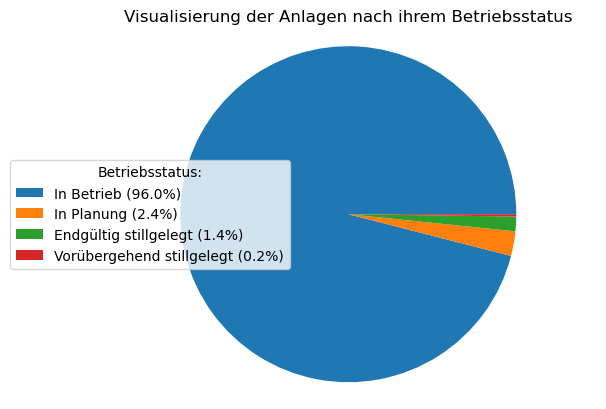

In [52]:
labels = [''] * len(values_betriebsstatus) 

plt.pie(values_betriebsstatus, labels=labels)
plt.axis('equal')
plt.title('Visualisierung der Anlagen nach ihrem Betriebsstatus')

total = sum(values_betriebsstatus)
plt.legend(title="Betriebsstatus:", loc="center", bbox_to_anchor=(0.1, 0.5), ncol=1, fancybox=True,
           labels=['{} ({:.1f}%)'.format(label, value/total*100) for label, value in zip(values_betriebsstatus.index, values_betriebsstatus)])

plt.show()

**d) Gesamte in Bayern installierte Nettonennleistung in Gigawatt**

Um die gesamte installierte Nettonennleistung in Gigawatt zu erhalten, berechnen wir als erstes die Summe der installierten Nettonennleistung aller Anlagen, die in Betrieb sind, danach wandeln wir die Summe der Nettonennleistung von Kilowatt in Gigawatt um:

In [53]:
df_filtered = df_anlagen[df_anlagen["Betriebsstatus"] == "In Betrieb"]

sum_nettonennleistung_kw = df_filtered["Nettonennleistung in kW"].sum()

In [54]:
sum_nettonennleistung_gw = sum_nettonennleistung_kw / 1000000
sum_nettonennleistung_gw

2.617772

Die gesamte installierte Nettonennleistung in Bayern beträgt **2.73** Gigawatt.

**e) Durchschnittliche Nettonennleistung einer Anlage und bei Teil- bzw. Volleinspeisern**

Für die durchschnittliche Nettonennleistung einer Anlage berechnen wir den Durchschnitt der Spalte **Nettonennleistung in kW**. Um den Durchschnitt für die Teil- und Volleinspeiser auszurechnen, filtern wir erst die jeweiligen Einspeiser in geeignete Variablen und rechnen dann anhand dieser Variablen den dazugehörigen Durchschnitt aus:

In [55]:
voll_einspeiser = df_filtered[df_filtered['Voll-/Teileinspeisung'].str.contains('Voll')]
teil_einspeiser = df_filtered[df_filtered['Voll-/Teileinspeisung'].str.contains('Teil')]

In [56]:
durchschnittl_leistung_allg = df_filtered['Nettonennleistung in kW'].mean()
durchschnittl_leistung_voll = voll_einspeiser['Nettonennleistung in kW'].mean()
durchschnittl_leistung_teil = teil_einspeiser['Nettonennleistung in kW'].mean()

In [57]:
durchschnittl_leistung_allg

2018.3284502698534

In [58]:
durchschnittl_leistung_voll #inaktive inkludiert

2231.2407574391345

In [59]:
durchschnittl_leistung_teil

642.396449704142

Die durchschnittliche Leistung einer Anlage beträgt **2018,66 kW**.  
Bei **Volleinspeisern** liegt die durchschnittliche Leistung bei **2250,81 kW**.  
Bei **Teileinspeisern** liegt die durchschnittliche Leistung bei **596,36 kw**.

**f) Anteil der Anlagen, bei denen eine natürliche Person als Betreiber hinterlegt ist**

Als erstes prüfen wir, ob eine "natürliche Person" in der Spalte "Anlagenbetreiber" überhaupt vorkommt. Ist dies der Fall, wird die Anzahl der Anlagen mit einer natürlichen Person als Betreiber gezählt. Anschließend wird der Gesamtanteil davon berechnet.

In [60]:
is_natuerliche_person = df_anlagen["Anlagenbetreiber"].str.contains("natürliche Person", case=False, na=False)

In [61]:
anzahl_natuerliche_person = df_anlagen[is_natuerliche_person].shape[0]

In [62]:
gesamt_anzahl = df_anlagen.shape[0]
anteil_natuerliche_person = anzahl_natuerliche_person / gesamt_anzahl * 100
anteil_natuerliche_person

12.509252405625462

Der Anteil der Anlagen mit einer natürlichen Person als Betreiber beträgt **12.5%**.

**g) Die 5 Hersteller, von denen die meisten Anlagen stammen**

Für die Top 5 Hersteller zählen wir die Häufigkeit der einzelnen Hersteller und geben diese aus:

In [63]:
top_hersteller = df_anlagen["Hersteller"].value_counts().head(5)

Die fünf Hersteller mit den meisten Anlagen in Bayern sind: 

In [64]:
print(top_hersteller)

ENERCON GmbH               372
Nordex Energy GmbH         234
Vestas Deutschland GmbH    229
Nordex SE                   79
GE Wind Energy GmbH         63
Name: Hersteller, dtype: int64


**h) Der am häufigsten verbaute Anlagentyp und die Häufigkeit**

Um Herauszufinden, welcher der häufigst verbaute Anlagentyp ist, haben wir zunächst ermittelt, welche Typenbezeichnungen wie oft  vorkommen. Die Bezeichnung des Anlagentyps, der am häufigsten verbaut ist, wird dann in eine extra Variable gespeichert und dessen Häufigkeit ebenso.

In [65]:
anlagentypen = df_anlagen['Typenbezeichnung'].value_counts()
anlagentypen.head(50)

N-117           259
E-82            132
V-90             98
V-112            86
E-101            55
GE 2.75-120      53
E-40             51
E-115            31
-                28
E-92             27
V-126            26
N-131            24
3.2M114          23
N-100            22
E-70             22
E-66             17
MD77             14
E-58             13
D-6              10
3.4M122 NES      10
112               9
V-82              9
Antaris           6
SkyWind NG        6
3.0M122           6
D4                5
E-53              5
S77               5
E-138             4
MM92              4
120-3000          4
V162-6.2          4
V47               3
N 149 4.5         3
E-160 EP5 E3      3
PWE650            3
GE 1,5 SL         3
Heywind 5 KW      3
GE Wind 2.75      3
NM82/1500         3
GE - 2.5 MW       2
FlowerW           2
Frisia F56        2
Aircon 10 S       2
Windspot          2
V136              2
E-48              2
Windcarrier       2
Vensys 136        2
FL2500            2


In [66]:
meist_anlagentyp = anlagentypen.index[0]
meist_anlagentyp

'N-117'

In [67]:
wie_oft = anlagentypen.iloc[0]
wie_oft

259

Der am häufigsten verbaute Anlagentyp ist **N-117** mit einer Häufigkeit von **259**.

# Aufgabe 3
**Interaktive Karte mit **folium** erstellen, mit Markern als Standorte für die jeweiligen Anlagen**

Die interaktive Karte haben wir mit der empfohlenen Biblitohek **folium** erstellt, hierbei durchlaufen wir mit einer for-Schleife die Zeilen unseres Dataframes. Dabei werden die Koordinaten vom Längen- und Breitengrad für die Marker und der Name des Windparks, das Datum der Inbetriebnahme und die Nettonennleistung für die Pop-Ups extrahiert. Die einzelnen Marker werden dann zu einem Marker-Cluster zusammengefügt, damit es übersichtlicher ist. Damit bei der Karte gleich auf Bayern gezoomt wird, haben wir die Koordinaten von der OTH Amberg-Weiden als Zoom-Punkt hergenommen.

In [68]:
campus_latitude = 49.44432
campus_longitude = 11.84736

standorte_karte = folium.Map(location=[campus_latitude, campus_longitude], zoom_start=7)

In [69]:
marker_cluster = MarkerCluster().add_to(standorte_karte)

for index, row in df_anlagen.iterrows():
    breitengrad = row['Breitengrad']
    laengengrad = row['Längengrad']
    
    name_windpark = row['Name Windpark']
    datum_inbetriebnahme = row['Datum erst. Inbetriebnahme']
    nettonennleistung = row['Nettonennleistung in kW']
    
    popup_text = f"<b>Name Windpark:</b> {name_windpark}<br><b>Datum Inbetriebnahme:</b> {datum_inbetriebnahme}<br><b>Nettonennleistung:</b> {nettonennleistung}"
    
    marker = folium.Marker(location=[breitengrad, laengengrad], popup=popup_text)
    marker_cluster.add_child(marker)

standorte_karte

# Aufgabe 4


**a) Fünf Windkraftanlagen, die sich am nähesten zur OTH in Amberg befinden**

Wir haben als erstes die Distanz zwischen den Koordinaten der Windkraftanlagen und den Koordinaten des Campus der OTH in Amberg berechnet. Dazu haben wir die Funktion **"calculate_distance"** definiert und eine neue Spalte **"Distanz_zum_Campus in km"** zum DataFrame **"df_anlagen"** hinzugefügt. Anschließend haben wir den DataFrame nach der Distanz zum Campus sortiert und den sortierten DataFrame in der Variable **"df_sorted"** gespeichert.

In [70]:
campus_latitude = 49.44432
campus_longitude = 11.84736

def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

df_anlagen.insert(df_anlagen.columns.get_loc("Längengrad") + 1, "Distanz_zum_Campus in km", df_anlagen.apply(lambda row: calculate_distance(row["Breitengrad"], row["Längengrad"], campus_latitude, campus_longitude), axis=1))

df_sorted = df_anlagen.sort_values(by="Distanz_zum_Campus in km")

Die fünf Windkraftanlagen am nähesten zum Campus der OTH in Amberg sind:

In [71]:
df_sorted.head(5)

,Name Stromerzeugungseinheit MaStR,Name Windpark,MaStR-Nummer der Einheit,Anlagenbetreiber,Betriebsstatus,Datum erst. Inbetriebnahme,Postleitzahl,Standort,Breitengrad,Längengrad,Distanz_zum_Campus in km,Nettonennleistung in kW,Nabenhöhe,Rotordurchmesser,Hersteller,Typenbezeichnung,Voll-/Teileinspeisung,Genehmigungsdatum,Installierte Leistung
699,Kommunalwindrad Ursensollen,Windpark Ursensollen,SEE901337432192,Kommunal,In Betrieb,2013-07-13,92289,Ursensollen,49.413067,11.727795,9.344046,2400,140.0,116.800003,Nordex Energy GmbH,N-117,Volleinspeisung,06.08.2012,2.400 kW
700,Bürgerwindrad Ursensollen,Windpark Ursensollen,SEE936857833082,Bürgerwindenergie Ursensollen GmbH & Co. KG,In Betrieb,2013-07-11,92289,Ursensollen,49.414692,11.723473,9.571929,2400,140.0,116.800003,Nordex Energy GmbH,N-117,Volleinspeisung,06.08.2012,2.400 kW
956,ABR990906480276,Wind onshore,SEE971708044446,ABR990906480276 (natürliche Person),In Betrieb,2011-11-10,92272,Freudenberg,49.463928,11.981148,9.942338,65,9.0,5.000000,BRAUN Windturbinen GmbH,Antaris 6.0 KW,Teileinspeisung (einschließlich Eigenverbrauch),NaN,"6,5 kW"
907,E2104101S160000000000048983400001,Laubberg,SEE919627517719,Horsch Energie GmbH &Co.KG,In Betrieb,2013-07-18,NaN,Wappersdorf 1,49.360645,11.797216,9.992442,3170,143.0,114.000000,REpower Systems SE,3.2M114,Volleinspeisung,21.12.2011,3.170 kW
910,WEA2,Laubberg,SEE955360388674,Horsch Energie GmbH &Co.KG,In Betrieb,2013-07-15,NaN,Wappersdorf 1,49.357437,11.798331,10.297352,3170,143.0,114.000000,REpower Systems SE,Repower 3.2 M114,Volleinspeisung,21.12.2011,3.170 kW


**b) Anzahl der in Betrieb genommenen Windkraftanlagen pro Jahr**

Um die Anzahl der in Betrieb genommenen Windkraftanlagen pro Jahr zu ermitteln, haben wir eine neue Spalte **"Jahr der Inbetriebnahme"** basierend auf der Spalte **"Datum erst. Inbetriebnahme"** hinzugefügt. Anschließend haben wir den DataFrame nach dem Betriebsstatus "In Betrieb" gefiltert und die Anzahl der Einträge pro Jahr gruppiert. Das Ergebnis wurde in der Variable "anzahl_pro_jahr_in_betrieb" gespeichert. Mit diesen Variablen konnten wir dann das Liniendiagramm zeichnen.

In [72]:
index = df_anlagen.columns.get_loc('Datum erst. Inbetriebnahme')

df_anlagen.insert(index + 1, 'Jahr der Inbetriebnahme', pd.to_datetime(df_anlagen['Datum erst. Inbetriebnahme']).dt.year)

In [73]:
df_in_betrieb = df_anlagen[df_anlagen['Betriebsstatus'] == 'In Betrieb']

anzahl_pro_jahr_in_betrieb = df_in_betrieb.groupby('Jahr der Inbetriebnahme').size()

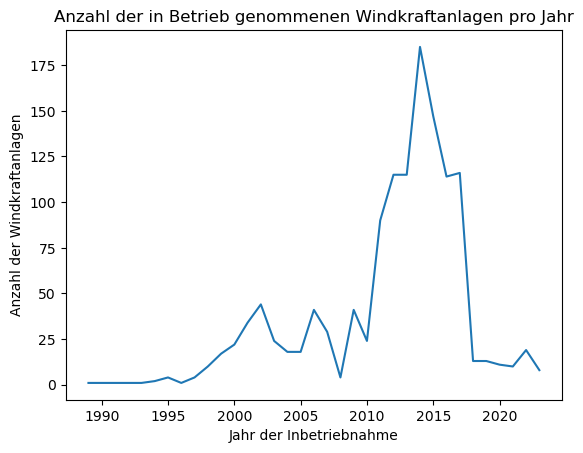

In [74]:
plt.plot(anzahl_pro_jahr_in_betrieb.index, anzahl_pro_jahr_in_betrieb.values)
plt.xlabel('Jahr der Inbetriebnahme')
plt.ylabel('Anzahl der Windkraftanlagen')
plt.title('Anzahl der in Betrieb genommenen Windkraftanlagen pro Jahr')
plt.show()

**Leichter Anstieg ab 2000:**

Das Erneuerbare-Energien-Gesetz (EEG) wurde im Jahr 2000 eingeführt und in den folgenden Jahren mehrmals überarbeitet. Es spielte eine zentrale Rolle bei der Förderung des Ausbaus erneuerbarer Energien, darunter auch der Windenergie. Das EEG legte verbindliche Einspeisevergütungen für den erzeugten Windstrom fest, was den Investoren eine langfristige Planungssicherheit bot. Dadurch wurden Anreize geschaffen, in den Ausbau von Windkraftanlagen zu investieren und die erzeugte Energie ins Stromnetz einzuspeisen. Das EEG trug somit maßgeblich zur Entwicklung und Wachstum der Windenergiebranche bei, indem es eine verlässliche finanzielle Unterstützung und ein attraktives Geschäftsmodell für Investoren bot. Die gesetzlichen Regelungen des EEG legten die Grundlage für den Ausbau der Windenergie in Deutschland und trugen dazu bei, dass erneuerbare Energien einen immer größeren Anteil an der Stromerzeugung in Deutschland einnehmen konnten.


**Starker Anstieg ab 2009:**

*Kyoto Protokoll(2008-2012): Deutschland hatte sich verpflichtet, im Rahmen des Kyoto-Protokolls die Treibhausgasemissionen im Zeitraum 2008-2012 um durchschnittlich 21% gegenüber dem Basisjahr 1990 zu reduzieren.

*Klimaschutzziel 2020: "Im Rahmen des Klima- und Energiepaketes hat sich die EU zu Zielen für 2020 verpflichtet. Die 2009 in Kraft getretenen Regelungen enthielten folgende Verpflichtungen" (siehe Link Umweltbundesamt)
    
*Energiewende und Atomausstieg: Nach der Nuklearkatastrophe von Fukushima im Jahr 2011 hat Deutschland beschlossen, aus der  Nutzung der Kernenergie auszusteigen und verstärkt auf erneuerbare Energien zu setzen. Die Energiewende beinhaltet den Ausbau erneuerbarer Energien, die Steigerung der Energieeffizienz und den Ausstieg aus der Kernenergie bis zum Jahr 2022.
    
    
**Starker Abstieg ab 2015:**

*Einführung der 10H-Regelung am 21.11.2014: Windenergieanlagen müssen einen Mindestabstand vom 10-fachen ihrer Höhe zu geschützten Wohngebäuden einhalten (Bayerische Bauordnung) "Vor der 10-H-Regelung wurden im Jahr 2013 noch über 400 Genehmigungsanträge für neue Windenergieanlagen gestellt, heute im Jahr 2019 sind dies weniger als zehn. (siehe Link bund-naturschutz)


**Kleiner Anstieg ab 2021:**

*EU-Klimagesetz 2021: Ziel der Klimaneutralität ab 2050


**c) Gesamte Nettonennleistung im zeitlichen Verlauf**

Zunächst haben wir den DataFrame nach dem Betriebsstatus "In Betrieb" gefiltert und die Nettonennleistung für jedes Jahr summiert. Anschließend haben wir die kumulative Nettonennleistung pro Jahr berechnet und ein Säulendiagramm erstellt, um die Entwicklung zu visualisieren.

In [75]:
df_in_betrieb = df_anlagen[df_anlagen['Betriebsstatus'] == 'In Betrieb']

nettonennleistung_in_betrieb = df_in_betrieb.groupby('Jahr der Inbetriebnahme')['Nettonennleistung in kW'].sum()

kumulative_nettonennleistung_in_betrieb = nettonennleistung_in_betrieb.cumsum()

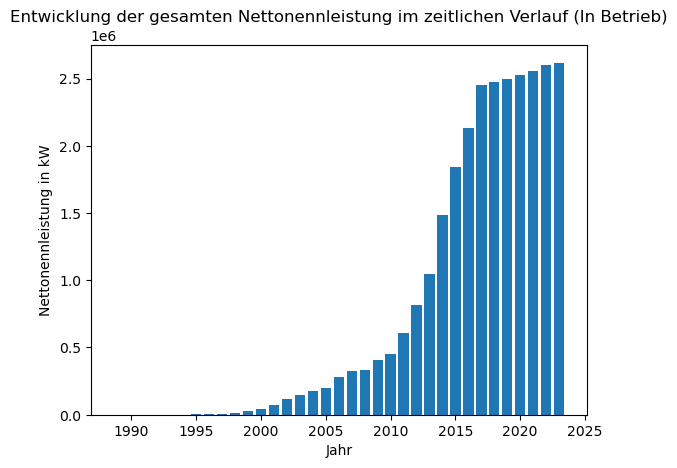

In [76]:
plt.bar(kumulative_nettonennleistung_in_betrieb.index, kumulative_nettonennleistung_in_betrieb.values)
plt.xlabel('Jahr')
plt.ylabel('Nettonennleistung in kW')
plt.title('Entwicklung der gesamten Nettonennleistung im zeitlichen Verlauf (In Betrieb)')
plt.show()

Wie man am Säulendiagramm sehen kann, hat sich die Nettonennleistung in kW jedes Jahr etwas erhöht. Von 1995 bis 2010 gab es erstmal nur kleine Anstiege, größerer Anstiege gab es dann von 2010 bis 2013 als dann die rapiden Anstiege von 2014 bis 2017 erfolgten. Den größen Anstieg gab es im Jahr 2014. Ab 2017 sind die Anstiege der Nettonennleistung wieder sehr gering.

**d) Verteilung der Nabenhöhen der Windkraftanlagen**

Für die Verteilung der Nabenhöhe, haben wir als erstes die Häufigkeit der vorhandenen Nabenhöhen gezählt um uns einen Überblick zu verschaffen. Danach haben wir uns zur besseren Untersuchung für ein Histogramm entschieden, da Häufigkeitsverteilungen häufig mit dieser Diagrammart visualisiert werden.

In [77]:
nabenhoehe_count = df_anlagen["Nabenhöhe"].value_counts()
nabenhoehe_count

141.000000    143
140.000000    120
139.000000     89
105.000000     86
140.600006     85
             ... 
16.000000       1
98.300003       1
9.800000        1
52.000000       1
25.250000       1
Name: Nabenhöhe, Length: 135, dtype: int64

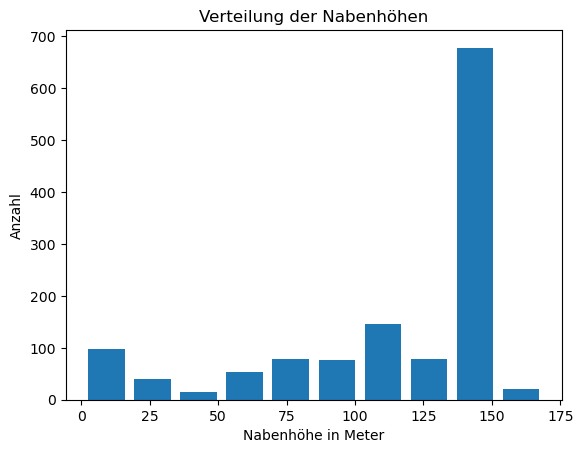

In [78]:
df_anlagen['Nabenhöhe'].plot(kind='hist', bins=10, rwidth=0.8)
plt.xlabel('Nabenhöhe in Meter')
plt.ylabel('Anzahl')
plt.title('Verteilung der Nabenhöhen')
plt.show()

Man erkennt sofort, dass die meisten Nabenhöhen zwischen ca. 140 und 150 Meter liegen. Am wenigsten gibt es Naben, die gerade mal 40-50 Meter hoch sind oder die ca. 160 Meter hoch. Es gibt aber auch viele Windkrafträder, die nur ca. 10 Meter hoch sind oder ca. 110 Meter. Ansonsten schwanken viele Naben zwischen den Höhen 60 und 125 Meter.

**e) Graphisch den Zusammenhang zwischen dem Rotordurchmesser und der Nabenhöhe der Anlagen untersuchen.**

Um den Zusammenhang zwischen dem Rotordurchmesser und der Nabenhöhe zu visualisieren, haben wir ein Streudiagramm (Scatter-Plot) erstellt. Durch das Streudiagramm, kann man den Zusammenhang sehr gut erkennen. Die Punkte im Diagramm repräsentieren die einzelnen Windkraftanlagen, wobei jede Punktfarbe für eine bestimmte Nabenhöhe steht. Der Zusammenhang zwischen dem Rotordurchmesser und der Nabenhöhe kann durch die Verteilung und Ausrichtung der Punkte im Diagramm beobachtet werden.

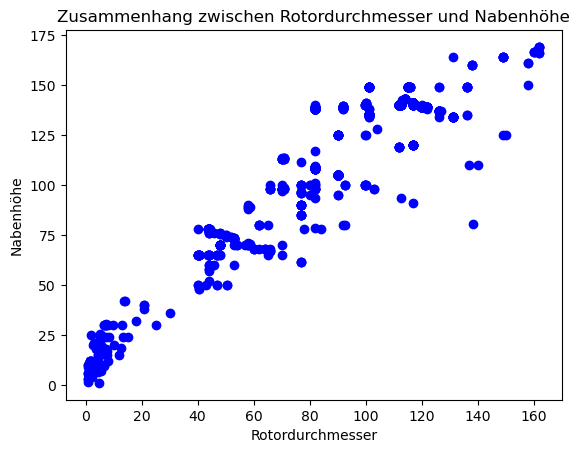

In [79]:
plt.scatter(df_anlagen["Rotordurchmesser"], df_anlagen["Nabenhöhe"], color="blue")
plt.xlabel('Rotordurchmesser')
plt.ylabel('Nabenhöhe')
plt.title('Zusammenhang zwischen Rotordurchmesser und Nabenhöhe')
plt.show()

Man sieht, dass die meisten Windkraftanlagen, die in der Höhe sehr klein ausfallen, auch kleine Rotorendurchmesser haben. Nur wenige sehr große Windkraftanlagen, haben dementsprechend auch große Rotoren. Die restlichen Windkraftanlagen, die in der Mitte der Nabenhöhe liegen, haben auch einen mittelgroßen Durchmesser für die Rotoren. Bei diesem Diagramm ist auch sofort erkennbar, dass linearer Zusammenhang existiert, im Folgenden rechnen wir dazu den Korrelationseffizienten aus:

In [80]:
correlation = df_anlagen['Rotordurchmesser'].corr(df_anlagen['Nabenhöhe'])
correlation

0.938918705656887

Das Ergebnis des Korrelationskoeffizienten ist 0.93, also sehr nah bei 1, das heißt, dass der lineare Zusammenhang zwischen dem Rotordurchmesser und der Nabenhöhe sehr stark ausgeprägt ist. Man kann also sagen, dass die Größe der Rotorendurchmesser durchaus von der Nabenhöhe einer Windkraftanlage abhängt.

**f) Zeit, die zwischen dem Genehmigungsdatum und dem Datum der erstmaligen Inbetriebnahme einer Einheit vergeht**

Zuerst haben wir ein temporäres DataFrame erstellt, um die NaN-Werte in der Spalte "Genehmigungsdatum" zu entfernen und eine genauere Berechnung durchzuführen. Da wir 439 fehlende Werte in der Spalte "Genehmigungsdatum" festgestellt haben, haben wir diese Werte vorerst gelöscht. Anschließend haben wir die Spalte "Genehmigungsdatum" in den Datentyp "datetime" umgewandelt, um die Zeitdifferenz zwischen dem Genehmigungsdatum und dem Datum der erstmaligen Inbetriebnahme berechnen zu können.

In [81]:
df_temp = df_anlagen

In [82]:
df_temp = df_anlagen.dropna(subset=["Genehmigungsdatum"])

In [83]:
df_temp['Genehmigungsdatum'] = pd.to_datetime(df_temp['Genehmigungsdatum'], format="%d.%m.%Y")

C:\Users\Julia\AppData\Local\Temp\ipykernel_22312\42906130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Genehmigungsdatum'] = pd.to_datetime(df_temp['Genehmigungsdatum'], format="%d.%m.%Y")


In [84]:
df_temp['Genehmigungsdatum']

0      2016-03-24
1      2014-03-26
3      2014-03-26
4      2010-06-24
7      2013-12-16
          ...    
1338   2023-02-24
1340   2022-10-31
1341   2022-10-31
1342   2022-11-02
1343   2022-11-02
Name: Genehmigungsdatum, Length: 912, dtype: datetime64[ns]

In [85]:
df_temp['Zeit bis Inbetriebnahme'] = df_temp['Datum erst. Inbetriebnahme'] - df_temp['Genehmigungsdatum']

C:\Users\Julia\AppData\Local\Temp\ipykernel_22312\76488100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Zeit bis Inbetriebnahme'] = df_temp['Datum erst. Inbetriebnahme'] - df_temp['Genehmigungsdatum']


In [86]:
df_temp['Zeit bis Inbetriebnahme']

0      208 days
1      259 days
3      259 days
4      279 days
7      302 days
         ...   
1338   187 days
1340   426 days
1341   426 days
1342   424 days
1343   424 days
Name: Zeit bis Inbetriebnahme, Length: 912, dtype: timedelta64[ns]

In [87]:
durchschnitt_zeit = df_temp['Zeit bis Inbetriebnahme'].mean().days
durchschnitt_zeit

519

Durchschnittlich vergeht zwischen dem Genehmigungsdatum und dem Datum der erstmaligen Inbetriebnahme **519 Tage**.

# Aufgabe 5

**a) Funktion namens get_weather_data(lon, lat, start_date, end_date, hourly=None) für Erstellung eines DataFrames, der die stündlichen Wetterdaten bezieht**

Wir haben hier eine Funktion namens "get_weather_data" implementiert, um einen DataFrame mit stündlichen Wetterdaten zu erstellen.  

Die Funktion erwartet die Längen- und Breitengrad-Koordinaten des Standorts, den Start- und Enddatum des Betrachtungszeitraums und optional eine Liste der zu beziehenden Variablen. 

Der Funktion wird eine URL mit den angegebenen Parametern für die Anfrage an die Open-Meteo API erstellt. Wenn die optionalen stündlichen Variablen angegeben wurden, werden sie zur URL hinzugefügt, andernfalls werden standardmäßige Wettervariablen wie Temperatur, Schneefall, Windgeschwindigkeit verwendet.

Die Funktion sendet die Anfrage an die API, erhält die Wetterdaten als JSON-Format zurück und erstellt einen DataFrame aus den stündlichen Daten.

Anschließend haben wir die Funktion angewendet, um historische Wetterdaten für den Campus der OTH in Amberg für den Zeitraum von 2020 bis 2022 zu beziehen. Wir haben die Koordinaten des Campus, das Start- und Enddatum sowie die stündlichen Variablen "temperature_2m" und "snowfall" angegeben.

Die erhaltenen Wetterdaten wurden in den DataFrame "df_weather_amb" gespeichert und dienen als Grundlage für alle weiteren Teilaufgaben im Zusammenhang mit dem Wetter.

In [88]:
def get_weather_data(lon, lat, start_date, end_date, hourly=None):
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}"
    
    if hourly:
        hourly_values = ",".join(hourly)
        url += f"&hourly={hourly_values}"
    else:
        url += "&hourly=temperature_2m,snowfall,windspeed_10m,windspeed_100m"
    
    response = requests.get(url)
    data = response.json()
    
    df = pd.DataFrame(data["hourly"])
    
    return df

In [2]:
campus_lat = 49.4443682
campus_lon = 11.8473979

start_date = "2020-01-01"
end_date = "2022-12-31"

hourly = ["temperature_2m","snowfall"]

In [3]:
df_weather_amb = get_weather_data(campus_lon, campus_lat, start_date, end_date, hourly)

NameError: name 'get_weather_data' is not defined

In [ ]:
df_weather_amb

**b) Tagen in Amberg, an denen es im Betrachtugnszeitraum geschneit hat**

Wir haben hier eine Funktion namens "count_snowy_days" implementiert, um zu ermitteln, an wie vielen Tagen im Betrachtungszeitraum in Amberg Schnee gefallen ist.

In der Funktion wird der übergebene DataFrame mit den Wetterdaten verwendet. Zunächst wird das Datum in das richtige Datumsformat konvertiert, indem die Spalte "time" in einen datetime-Datentyp umgewandelt wird.

Anschließend wird aus der Zeitinformation das Datum extrahiert und in der neuen Spalte "date" des DataFrames gespeichert.

Der DataFrame wird nach Schneefallwerten überprüft, indem nach Zeilen gesucht wird, in denen der Wert in der Spalte "snowfall" größer als 0 ist. Die eindeutigen Datumsangaben dieser Tage mit Schneefall werden gezählt, indem die Anzahl der eindeutigen Werte in der Spalte "date" ermittelt wird.

Das Ergebnis, die Anzahl der Tage mit Schneefall im Betrachtungszeitraum, wird zurückgegeben.

Wir haben die Funktion angewendet, indem wir den DataFrame "df_weather_amb" mit den Wetterdaten von Amberg verwendet haben. Dadurch konnten wir ermitteln, an wie vielen Tagen im Betrachtungszeitraum Schnee in Amberg gefallen ist.

In [ ]:
def count_snowy_days(weather_df):
    weather_df['time'] = pd.to_datetime(weather_df['time'])

    weather_df['date'] = weather_df['time'].dt.date

    snowy_days = weather_df[weather_df['snowfall'] > 0]['date'].nunique()

    return snowy_days

In [ ]:
count_snowy_days(df_weather_amb)

In Amberg hat es an **144 Tagen** geschneit.

**c) CorrelationHeatmap der Wetterdaten fur Amberg**


Wir haben eine Liste von stündlichen Wettervariablen definiert, die in die Korrelationsanalyse einbezogen werden sollen.

Anschließend haben wir die Funktion "get_weather_data" verwendet, um den DataFrame "df_weather_amb_2" mit den entsprechenden Wetterdaten für den definierten Zeitraum und die definierten Variablen zu erhalten.

Wir haben dann die Korrelationsmatrix des DataFrames berechnet, indem wir die Funktion "corr" angewendet haben. Diese Matrix zeigt die Korrelationskoeffizienten zwischen allen Paaren von Wettervariablen.

Um die Korrelations-Heatmap zu erzeugen, haben wir die Funktion "heatmap" aus der Bibliothek "seaborn" verwendet. Die Heatmap wurde mit Anmerkungen (Korrelationskoeffizienten), einer Farbpalette ('coolwarm') und einem Format für die Anzeige der Werte formatiert.

In [4]:
hourly = ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'rain', 'snowfall', 'cloudcover', 'windspeed_10m']
df_weather_amb_2 = get_weather_data(campus_lon, campus_lat, start_date, end_date, hourly)
df_weather_amb_2

NameError: name 'get_weather_data' is not defined

In [5]:
correlation_matrix = df_weather_amb_2.corr()

NameError: name 'df_weather_amb_2' is not defined

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korrelations-Heatmap der Wetterdaten')
plt.show()

NameError: name 'correlation_matrix' is not defined

<Figure size 1000x800 with 0 Axes>

Aus der Heatmap erkennt man sofort, dass zwischen der Temperatur und dem Taupunkt ein hoher positiver Korrelationswert besteht, heißt, das bei einer hohen Temperatur der Tau stärker ist, was man im realen Leben auch so sehen kann. Ebenso sieht man, dass zwischen der Luftfeuchtigkeit und der Wolkenbedeckung ebenso ein höherer, positiver Wert mit 0.40 ist, auch diese zwei Variablen haben einen Zusammenhang, denn mit aufsteigender Luftfeuchtigkeit nach oben, entstehen mehr Wolken. Auch zwischen Regen und Wolkenbildung gibt es einen positiven Wert von 0.26, worin auch ein Zusammenhang erkennbar ist, denn bei Wolkenbildung, ist die Gefahr von Regen höher. Auch der positive Wert von 0.19 zwischen Regen und Luftfeuchtigkeit lässt sich erklären, denn wenn es regnet, ist die Luftfeuchtigkeit auch höher. Ein hoher negativer Wert zwischen der Temperatur und Luftfeuchtigkeit sticht einem auch sofort ins Auge und das lässt sich auch damit erklären, dass bei einer hohen Temperatur die Luftfeuchtigkeit sehr niedrig ist.

**d) Durchschnittliche Temperatur und die durchschnittlichen Windstärken (in 10m und 100m Höhe) pro Tag im Betrachtungszeitraum in geeigneten Diagrammen visualisieren**

Zuerst haben wir die Koordinaten des Campus der OTH in Amberg, das Start- und Enddatum sowie die stündlichen Wettervariablen definiert.

Mit der Funktion "get_weather_data" haben wir den DataFrame "df_weather_amb" erhalten, der die entsprechenden Wetterdaten für den definierten Zeitraum und die definierten Variablen enthält.

Dann haben wir die Funktion "count_average" verwendet, um den Durchschnittswert der Temperatur und der Windgeschwindigkeiten in 10m und 100m Höhe pro Tag zu berechnen. Dafür haben wir den DataFrame "df_weather_amb" und die jeweilige Spalte als Argumente übergeben.

Wir haben zunächst ein Liniendiagramm erstellt, um die Entwicklung der durchschnittlichen Temperatur pro Tag darzustellen. Dabei wurde auf der x-Achse das Datum und auf der y-Achse die Durchschnittswerte der Temperatur in Grad Celsius dargestellt. 

Durch die Betrachtung des Diagramms können wir Trends und Muster in der Temperaturentwicklung im Betrachtungszeitraum erkennen und beschreiben.

Anschließend haben wir ein weiteres Liniendiagramm erstellt, um die durchschnittlichen Windstärken in 10m und 100m Höhe pro Tag zu visualisieren. Dabei wurden auf der x-Achse das Datum und auf der y-Achse die Durchschnittswerte der Windgeschwindigkeiten in km/h dargestellt.

In [97]:
campus_lat = 49.44
campus_lon = 11.84

start_date = "2020-01-01"
end_date = "2022-12-31"

hourly = ["temperature_2m","windspeed_10m","windspeed_100m" ]

In [98]:
df_weather_amb = get_weather_data(campus_lon, campus_lat, start_date, end_date, hourly)
df_weather_amb

,time,temperature_2m,windspeed_10m,windspeed_100m
0,2020-01-01T00:00,-0.8,4.0,9.0
1,2020-01-01T01:00,-1.1,4.0,6.7
2,2020-01-01T02:00,-0.7,2.6,4.7
3,2020-01-01T03:00,-0.4,4.0,7.6
4,2020-01-01T04:00,-0.4,3.6,6.6
...,...,...,...,...
26299,2022-12-31T19:00,11.2,15.5,32.0
26300,2022-12-31T20:00,10.8,15.0,31.7
26301,2022-12-31T21:00,10.5,14.8,31.4
26302,2022-12-31T22:00,10.3,14.5,30.8


In [99]:
def count_average(weather_df, column):
    weather_df['time'] = pd.to_datetime(weather_df['time'])

    weather_df['date'] = weather_df['time'].dt.date

    average_val = weather_df.groupby('date')[column].mean()

    return average_val

In [100]:
durchschnitt_temp = count_average(df_weather_amb, 'temperature_2m')

In [101]:
durchschnitt_wind_10m = count_average(df_weather_amb, 'windspeed_10m')

In [102]:
durchschnitt_wind_100m = count_average(df_weather_amb, 'windspeed_100m')

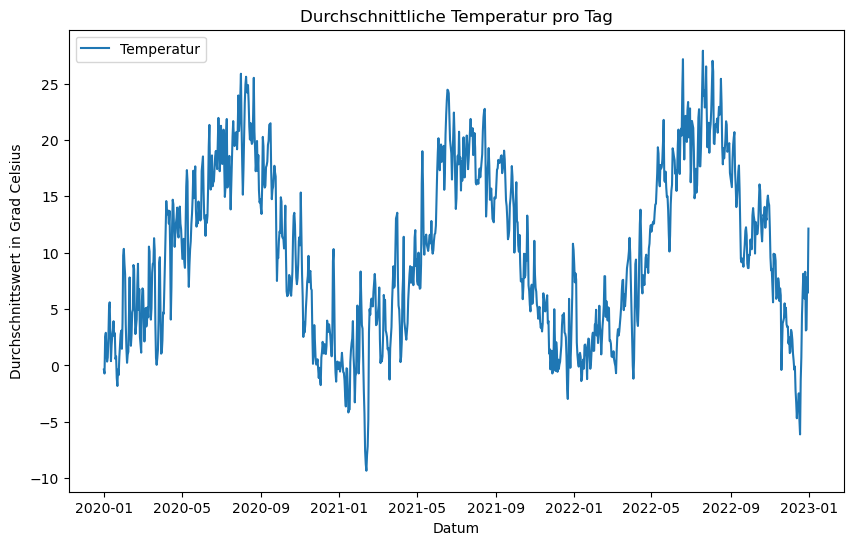

In [103]:
plt.figure(figsize=(10, 6))

plt.plot(durchschnitt_temp.index, durchschnitt_temp, label='Temperatur')

plt.title('Durchschnittliche Temperatur pro Tag')
plt.xlabel('Datum')
plt.ylabel('Durchschnittswert in Grad Celsius')

plt.legend()

plt.show()

Im Liniendiagramm für die Temperatur ist sofort zu sehen, dass sie am Anfang und am Ende des Jahres, in dem natürlich die Jahreszeit Winter herrscht, am niedrigsten ist. Besonders im Jahr 2021 war die Temperatur im Januar / Februar besonders niedrig und hat fast die -10 Grad erreicht. Auch am Ende des Jahres 2022 war die Temperatur besonders niedrig. In den Monaten von Mai bis September, in dem Sommer ist, ist die Temperatur sehr hoch. Im Jahr 2022 war der Sommer am wärmsten mit Temperaturen bis zu 30 Grad.

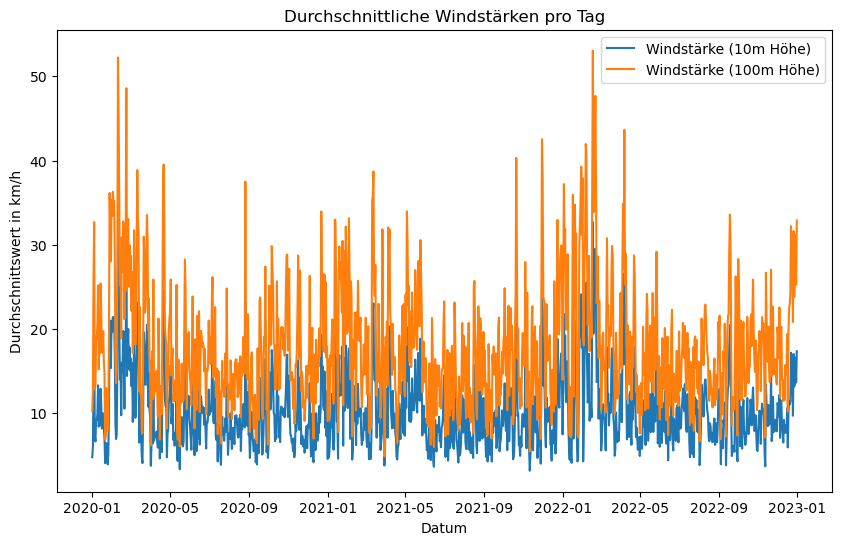

In [104]:
plt.figure(figsize=(10, 6))

plt.plot(durchschnitt_wind_10m.index, durchschnitt_wind_10m, label='Windstärke (10m Höhe)')

plt.plot(durchschnitt_wind_100m.index, durchschnitt_wind_100m, label='Windstärke (100m Höhe)')

plt.title('Durchschnittliche Windstärken pro Tag')
plt.xlabel('Datum')
plt.ylabel('Durchschnittswert in km/h')


plt.legend()

plt.show()

Im Liniendiagramm für die Windstärken ist gut erkennbar, dass die Windstärken in 100m Höhe ihren Höhepunkt bei über 50 km/h jedes Jahr zwischen Februar und Mai haben. Bei der Windstärke in 10m Höhe ist erkennbar, dass sie im Verlauf des Jahres einigermaßen gleich bleibt, nur immer am Anfang des Jahres auch ihren Höhepunkt mit ca. 30 km/h erreicht.

**e) Ein interaktives Säulendiagramm in Plotly für die durchschnittliche Windstärke im Verlauf eines Tages, bezogen auf die vollen Stunden eines Tages**

Wir haben hier DataFrames für verschiedene Jahreszeiten basierend auf den Windgeschwindigkeitsdaten erstellt. Wir haben den DataFrame "df_windspeed" mit den entsprechenden Daten erhalten. Dann haben wir separate DataFrames für die Wintermonate, Frühlingsmonate, Sommermonate und den Herbst erstellt, indem wir die Daten nach Monaten gefiltert haben. Dadurch können wir die Windgeschwindigkeiten in den verschiedenen Jahreszeiten analysieren und vergleichen.

In [105]:
campus_lat = 49.44
campus_lon = 11.84

start_date = "2020-01-01"
end_date = "2022-12-31"

hourly = ["windspeed_10m","windspeed_100m"]

In [106]:
df_windspeed = get_weather_data(campus_lon, campus_lat, start_date, end_date, hourly)
print(df_windspeed)

                   time  windspeed_10m  windspeed_100m
0      2020-01-01T00:00            4.0             9.0
1      2020-01-01T01:00            4.0             6.7
2      2020-01-01T02:00            2.6             4.7
3      2020-01-01T03:00            4.0             7.6
4      2020-01-01T04:00            3.6             6.6
...                 ...            ...             ...
26299  2022-12-31T19:00           15.5            32.0
26300  2022-12-31T20:00           15.0            31.7
26301  2022-12-31T21:00           14.8            31.4
26302  2022-12-31T22:00           14.5            30.8
26303  2022-12-31T23:00           14.7            31.5

[26304 rows x 3 columns]


In [107]:
df_windspeed['month'] = pd.to_datetime(df_windspeed['time']).dt.month
df_windspeed['hour'] = pd.to_datetime(df_windspeed['time']).dt.hour

winter_df = df_windspeed[df_windspeed['month'].isin([12, 1, 2])]

print(winter_df)

                   time  windspeed_10m  windspeed_100m  month  hour
0      2020-01-01T00:00            4.0             9.0      1     0
1      2020-01-01T01:00            4.0             6.7      1     1
2      2020-01-01T02:00            2.6             4.7      1     2
3      2020-01-01T03:00            4.0             7.6      1     3
4      2020-01-01T04:00            3.6             6.6      1     4
...                 ...            ...             ...    ...   ...
26299  2022-12-31T19:00           15.5            32.0     12    19
26300  2022-12-31T20:00           15.0            31.7     12    20
26301  2022-12-31T21:00           14.8            31.4     12    21
26302  2022-12-31T22:00           14.5            30.8     12    22
26303  2022-12-31T23:00           14.7            31.5     12    23

[6504 rows x 5 columns]


In [108]:
df_windspeed['month'] = pd.to_datetime(df_windspeed['time']).dt.month
df_windspeed['hour'] = pd.to_datetime(df_windspeed['time']).dt.hour

fruehling_df = df_windspeed[df_windspeed['month'].isin([3, 4, 5])]

print(fruehling_df)

                   time  windspeed_10m  windspeed_100m  month  hour
1440   2020-03-01T00:00           15.9            30.3      3     0
1441   2020-03-01T01:00           17.3            31.8      3     1
1442   2020-03-01T02:00           17.6            31.4      3     2
1443   2020-03-01T03:00           18.2            32.7      3     3
1444   2020-03-01T04:00           18.4            33.2      3     4
...                 ...            ...             ...    ...   ...
21163  2022-05-31T19:00           11.6             5.1      5    19
21164  2022-05-31T20:00           11.9            16.4      5    20
21165  2022-05-31T21:00           10.2            18.5      5    21
21166  2022-05-31T22:00            8.1             1.5      5    22
21167  2022-05-31T23:00            7.9             2.9      5    23

[6624 rows x 5 columns]


In [109]:
df_windspeed['month'] = pd.to_datetime(df_windspeed['time']).dt.month
df_windspeed['hour'] = pd.to_datetime(df_windspeed['time']).dt.hour


sommer_df = df_windspeed[df_windspeed['month'].isin([6, 7, 8])]

print(sommer_df)

                   time  windspeed_10m  windspeed_100m  month  hour
3648   2020-06-01T00:00            3.8            10.1      6     0
3649   2020-06-01T01:00            4.5            12.3      6     1
3650   2020-06-01T02:00            4.5            12.8      6     2
3651   2020-06-01T03:00            5.2            12.8      6     3
3652   2020-06-01T04:00            5.9            13.0      6     4
...                 ...            ...             ...    ...   ...
23371  2022-08-31T19:00            8.9            20.4      8    19
23372  2022-08-31T20:00            8.6            20.2      8    20
23373  2022-08-31T21:00            8.4            19.4      8    21
23374  2022-08-31T22:00            5.4            15.8      8    22
23375  2022-08-31T23:00            7.6            18.3      8    23

[6624 rows x 5 columns]


In [110]:
df_windspeed['month'] = pd.to_datetime(df_windspeed['time']).dt.month
df_windspeed['hour'] = pd.to_datetime(df_windspeed['time']).dt.hour

herbst_df = df_windspeed[df_windspeed['month'].isin([9, 10, 11])]

print(herbst_df)

                   time  windspeed_10m  windspeed_100m  month  hour
5856   2020-09-01T00:00            7.2            15.1      9     0
5857   2020-09-01T01:00            8.4            17.8      9     1
5858   2020-09-01T02:00            8.0            16.7      9     2
5859   2020-09-01T03:00            9.0            18.4      9     3
5860   2020-09-01T04:00            9.1            18.0      9     4
...                 ...            ...             ...    ...   ...
25555  2022-11-30T19:00            7.8            14.8     11    19
25556  2022-11-30T20:00            7.7            15.1     11    20
25557  2022-11-30T21:00            8.4            16.3     11    21
25558  2022-11-30T22:00            7.4            15.5     11    22
25559  2022-11-30T23:00            7.9            16.6     11    23

[6552 rows x 5 columns]


Anschließend haben wir eine interaktive Dashboard-Anwendung mit Hilfe von Dash erstellt. 

Zuerst haben wir die Dash-Anwendung initialisiert und das Layout definiert. Dabei haben wir Radiobuttons für die Auswahl der Jahreszeiten und der Windgeschwindigkeiten hinzugefügt.

Anschließend haben wir eine Callback-Funktion erstellt, die auf Änderungen der Radiobutton-Werte reagiert. Je nach ausgewählter Jahreszeit werden die entsprechenden Datenframes zugewiesen. Dann wird der Durchschnitt der Windgeschwindigkeiten nach Stunden gruppiert und ein Balkendiagramm erstellt.

Die aktualisierten Diagrammdaten werden an die Dash-Anwendung zurückgegeben und in der Anwendung angezeigt.

Schließlich starten wir die Anwendung mit der Methode app.run(debug=True).

In [111]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.Label('Auswahl Jahreszeiten:',  style={'font-family': 'Arial', 'font-size': '16px', 'font-weight': 'bold'}),  # Label hinzugefügt
    dcc.RadioItems(
        id='season-radio',
        options=[
            {'label': 'Frühling', 'value': 'Frühling'},
            {'label': 'Sommer', 'value': 'Sommer'},
            {'label': 'Herbst', 'value': 'Herbst'},
            {'label': 'Winter', 'value': 'Winter'},
            {'label': 'Alle', 'value': 'Alle'}
        ],
        value='Alle',
        style={'font-family': 'Arial', 'font-size': '14px'}
    )
], style={'display': 'inline-block', 'vertical-align': 'top'})

app.layout.children.append(html.Div([
    html.Label('Auswahl Windgeschwindigkeit:', style={'font-family': 'Arial', 'font-size': '16px', 'font-weight': 'bold'}),  # Label hinzugefügt
    dcc.RadioItems(
        id='windspeed-radio',
        options=[
            {'label': 'Windspeed 10m', 'value': 'windspeed_10m'},
            {'label': 'Windspeed 100m', 'value': 'windspeed_100m'},
        ],
        value='windspeed_10m',
        style={'font-family': 'Arial', 'font-size': '14px'}
    )
], style={'display': 'inline-block', 'vertical-align': 'top', 'margin-left': '300px', 'margin-top': '-112px'}))

app.layout.children.append(dcc.Graph(id='windspeed-chart'))

@app.callback(
    dash.dependencies.Output('windspeed-chart', 'figure'),
    [dash.dependencies.Input('season-radio', 'value'),
    dash.dependencies.Input('windspeed-radio', 'value')],
    
)
def update_output(season_value, windspeed_value):
    if season_value == 'Frühling':
        df = fruehling_df
    elif season_value == 'Sommer':
        df = sommer_df
    elif season_value == 'Herbst':
        df = herbst_df
    elif season_value == 'Winter':
        df = winter_df
    else:
        df = df_windspeed

    grouped_df = df.groupby('hour').mean()

    fig = go.Figure(data=[go.Bar(x=grouped_df.index, y=grouped_df[windspeed_value])])

    fig.update_layout(
        title='Durchschnittliche Windstärke im Verlauf eines Tages',
        xaxis_title='Stunde',
        yaxis_title='Durchschnittliche Windstärke in km/h',
        margin={'l': 0, 'r': 5, 't': 80, 'b': 0},
        width=800
    )
    fig.update_yaxes(range=[0, 25])
    fig.update_xaxes(tickvals=list(range(24)))

    return fig

if __name__ == "__main__":
    app.run(debug=True)


Anhand des Diagramms lässt sich sehr gut erkennen, dass in der Jahreszeit Frühling, der Wind bei 10m Höhe nachmittags gegen 13, 14 Uhr am stärksten ist. Hingegen flacht die Stärke des Windes gegen Abend ab und ist über die Nacht am schwächsten. Bei 100m Höhe lässt sieht man, dass es hier genau anders herum ist. Die Windstärke ist abends und nachts am stärksten und erreicht ihren Tiefpunkt vormittags um 10 Uhr.

Im Sommer ist erkennbar, dass der Wind vormittags um 9 Uhr etwas stärker ist und nachmittags gegen 14 und 15 Uhr am stärksten. Auch hier flacht der Wind gegen Abend ab und ist Nachts nicht mehr so stark. Die Windstärke bei 100m Höhe ist genauso wie im Frühling, dass es Nachts stärker als tagsüber ist.

Im Herbst sieht man, dass die Windstärke ihren Höhepunkt wieder vormittags um 9 Uhr und mittags um 12, 13 Uhr erreicht. Jedoch ist der Wind im Herbst nicht so stark wie im Frühling oder Sommer. Auch bei 100m Höhe ist Nachts der Wind stärker als tagsüber, hier erreicht sie ihren Tiefpunkt um 10 Uhr vormittags.

Im Winter erkennt man, dass die Windstärke allgemein viel stärker ist als in den anderen Jahreszeiten. Sie ist auch im Verlauf des Tages ziemlich gleichmäßig, der Höhepunkt wird dennoch um 9 Uhr vormittags und mittags um 12 bzw. 13 Uhr erreicht. Bei 100m Höhe sieht man, dass die Windstärke Nachts und in der Früh wieder gleichmäßig ist, flacht jedoch um 10 Uhr Vormittags wieder ab, erhöht sich aber dann wieder in nächsten Stunden.

Allgemein erkennt man über alle Jahreszeiten, dass die Windstärke bei 10m Höhe Vormittags und Mittag / Nachmittags am stärksten ist. Bei 100m Höhe ist sie ab 10 Uhr Vormittags etwas schwächer, baut sich dann aber die nächsten Stunden auf und ist dann gleichmäßig stark.

**f) Visualisieren Sie in einem Histogramm die Verteilung der Windstärke in 100m Höhe.**

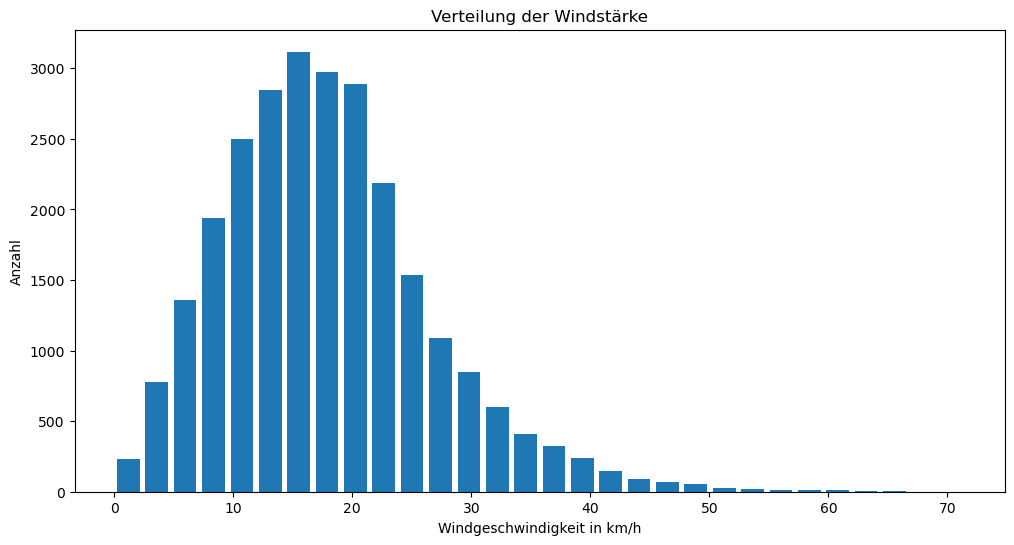

In [112]:
plt.figure(figsize=(12, 6))
df_windspeed['windspeed_100m'].plot(kind='hist', bins=30, rwidth=0.8)
plt.xlabel('Windgeschwindigkeit in km/h')
plt.ylabel('Anzahl')
plt.title('Verteilung der Windstärke')
plt.show()

# Aufgabe 6 
### Abschätzung des Ertrags von Windkraftanlagen, Standortplanung)

**a) Die Gesamtenergieerträge für alle bayerischen Windkraftanlagen vom Typ Nordex 117 für die Jahre 2020-2022**

Für die Gesamtenergieeträge aller bayerischen Windkraftanlagen vom Typ Nordex 117 haben wir die bereits zur Verfügung gestellte CSV-Datei mit dem Namen **"leistungskennlinie_nordex117.csv"** eingelesen und den Dataframe **"df_leistung_n117"** erstellt.

Dann haben wir den Dataframe df_anlagen nach den Windkraftanlagen des Typs N-117 gefiltert und den resultierenden Dataframe **"df_n117"** erhalten.

Wir haben einen weiteren Filter angewendet, um nur die Zeilen aus df_n117 beizubehalten, deren Nettonennleistung 2400 kW beträgt. Diesen Filter haben wir in der Variable leistung_filter definiert und auf df_n117 angewendet.

Anschließend haben wir einen weiteren Filter angewendet, um nur die N-117 Anlagen zu behalten, die bis 2023 in Betrieb genommen wurden. Diesen Filter haben wir in der Variable "inbetriebnahme_filter" definiert und auf df_n117 angewendet.

In [113]:
campus_lat = 49.4443682
campus_lon = 11.8473979

start_date = "2020-01-01"
end_date = "2022-12-31"

hourly = ["windspeed_100m"]

In [114]:
df_leistung_n117 = pd.read_csv("leistungskennlinie_nordex117.csv")
df_leistung_n117

,Windgeschwindigkeit [m/s],Leistung [kW]
0,0.0,0
1,0.5,0
2,1.0,0
3,1.5,0
4,2.0,0
5,2.5,0
6,3.0,25
7,3.5,90
8,4.0,154
9,4.5,255


In [115]:
df_n117 = df_anlagen[(df_anlagen['Typenbezeichnung'] == 'N-117')]

In [116]:
leistung_filter = df_n117['Nettonennleistung in kW'] == 2400

df_n117 = df_n117.loc[leistung_filter]

In [117]:
inbetriebnahme_filter = df_n117['Jahr der Inbetriebnahme'] < 2023

df_n117 = df_n117.loc[inbetriebnahme_filter]

Nun kommen wir zur weiteren Bearbeitung. Zunächst wird eine leere Liste namens "erzeugte_energie_liste" erstellt, in der wir die erzeugte Energie für jede Anlage speichern werden.

Dann haben wir den Startzeitpunkt und den Endzeitpunkt für den Betrachtungszeitraum festgelegt.  
Wir haben eine Bedingung erstellt, um zu überprüfen, ob das Jahr der Inbetriebnahme einer Anlage ab dem Jahr 2020 liegt.
Basierend auf dieser Bedingung haben wir die Anzahl der aktiven Tage für jede Anlage berechnet, indem wir die Differenz zwischen dem Endzeitpunkt und dem Inbetriebnahmedatum genommen haben. Wir haben die aktiven Tage in das Format von timedelta umgewandelt, indem wir die Funktion "pd.to_timedelta" verwendet haben. Dann haben wir den Index des Dataframes zurückgesetzt, um sicherzustellen, dass er fortlaufend ist.  

Anschließend haben wir eine leere Liste namens "df_weather_list" erstellt, in der wir die Wetterdaten für jede Anlage speichern werden. Wir haben mit einer Schleife den Dataframe df_n117 durchiteriert und für jede Anlage die Wetterdaten extrahiert. Danach wurde die Windgeschwindigkeit in m/s umgerechnet, indem wir sie durch 3,6 geteilt haben.

Die Windgeschwindigkeit haben wir auf ganze Zahlen oder auf 0,5 gerundet, um sie mit den Werten in der Leistungskennlinie vergleichen zu können. Die Windgeschwindigkeitswerte, die größer als 20,5 sind, haben wir mit 0 ersetzt, da dies auf einen Abschaltmechanismus hinweist. Den erzeugten Energieertrag haben wir anschließend für jede Windgeschwindigkeit basierend auf der Leistungskennlinie berechnet und summiert.

Zum Schluss wurde die erzeugte Energie für jede Anlage in die Liste "erzeugte_energie_liste" eingefügt.

In [ ]:
erzeugte_energie_liste = []

In [ ]:
startzeitpunkt = datetime.datetime(2020, 1, 1)
endzeitpunkt = datetime.datetime(2022, 12, 31)

mask = df_n117['Datum erst. Inbetriebnahme'].dt.year >= 2020

df_n117['Aktive Tage'] = np.where(mask, (endzeitpunkt - df_n117['Datum erst. Inbetriebnahme']).dt.days, endzeitpunkt - startzeitpunkt)

df_n117['Aktive Tage'] = pd.to_timedelta(df_n117['Aktive Tage'], unit='D')


df_n117 = df_n117.reset_index(drop=True)
df_n117

In [ ]:
df_weather_list = []

for index, row in df_n117.iterrows():
        aktuell_startzeitpunkt = endzeitpunkt - row['Aktive Tage']
        
        df_weather = get_weather_data(row['Längengrad'], row['Breitengrad'], aktuell_startzeitpunkt.date(), endzeitpunkt.date(), hourly=['windspeed_100m'])
        df_weather['Längengrad'] = row['Längengrad']
        df_weather['Breitengrad'] = row['Breitengrad']
        
        df_weather['windspeed_100m'] = df_weather['windspeed_100m'].astype(float)
        df_weather['windspeed_100m'] /= 3.6
        
        df_weather['windspeed_100m'] = (df_weather['windspeed_100m'] * 2).round() / 2
        
        df_weather.loc[df_weather['windspeed_100m'] > 20.5, 'windspeed_100m'] = 0
        df_weather_list.append(df_weather)
        
        erzeugte_energie = 0

        for windspeed in df_weather['windspeed_100m']:
            energie_ertrag = df_leistung_n117[df_leistung_n117['Windgeschwindigkeit [m/s]'] == windspeed]['Leistung [kW]'].values[0] * 1
            erzeugte_energie += energie_ertrag
            
        erzeugte_energie_liste.append(erzeugte_energie)


Nach dem Schleifen-Durchlauf haben wir die Dataframe-Liste "df_weather_list" dann mit der Funktion "pd.concat" zu einem einzigen Dataframe "df_weatherdata_complete" zusammengeführt.

Anschließend haben wir den "df_weatherdata_complete" in eine CSV-Datei mit dem Namen "n117_wetterdaten.csv" exportiert.

Wir haben die durchschnittlich erzeugte Energie pro Jahr berechnet und in einer neuen Spalte namens **"Durchschnittlich erzeugte Energie pro Jahr GWh"** im Dataframe "df_n117" gespeichert. Dabei haben wir unterschiedliche Berechnungen durchgeführt, abhängig von der Anzahl der aktiven Tage.

Wir haben die fünf Anlagen mit der höchsten durchschnittlich erzeugten Energie pro Jahr ausgewählt und in einem neuen Dataframe **"top_fuenf_anlagen"** gespeichert. Dazu haben wir die Funktion "nlargest" verwendet, die uns die n größten Werte in Bezug auf eine bestimmte Spalte zurückgibt. In unserem Fall war dies die Spalte "Durchschnittlich erzeugte Energie pro Jahr GWh".

In [ ]:
df_weatherdata_complete

In [ ]:
erzeugte_energie_liste

In [ ]:
df_n117['Erzeugte Energie in GWh'] = np.nan

df_n117['Erzeugte Energie in GWh'] = erzeugte_energie_liste

df_n117['Erzeugte Energie in GWh'] = df_n117['Erzeugte Energie in GWh'] / 1000000

df_n117.to_csv('n117_energieerträge.csv', index=False)

In [ ]:
df_n117['Durchschnittlich erzeugte Energie pro Jahr GWh'] = np.where(
    df_n117['Aktive Tage'] < 365, df_n117['Erzeugte Energie in GWh'],
    np.where(df_n117['Aktive Tage'] < 1095, df_n117['Erzeugte Energie in GWh'] / df_n117['Aktive Tage'] * 365,
             df_n117['Erzeugte Energie in GWh'] / 3))

In [ ]:
top_fuenf_anlagen = df_n117.nlargest(5, 'Durchschnittlich erzeugte Energie pro Jahr GWh')
top_fuenf_anlagen

**b) Geschätzter jährlicher Ertrag in den Jahren 2020-2022 für eine Anlage vom Typ Nordex 117 auf dem Campus der OTH in Amberg**

Wir haben hier die Wetterdaten für den angegebenen Zeitraum (startzeitpunkt bis endzeitpunkt) und den Standort (campus_lon, campus_lat) abgerufen. Dabei haben wir speziell die Windgeschwindigkeitsdaten in 100m Höhe (hourly=['windspeed_100m']) erhalten.

Um die Daten für die weitere Analyse vorzubereiten, haben wir die Windgeschwindigkeitswerte von Metern pro Sekunde (m/s) in Kilometer pro Stunde (km/h) umgewandelt, indem wir die Werte durch 3,6 geteilt haben.

Anschließend haben wir die Windgeschwindigkeitswerte auf ganze Zahlen oder auf 0,5 gerundet, da dies den Werten in der Leistungskennlinie entspricht. Wir haben auch Windgeschwindigkeitswerte, die größer als 20,5 km/h waren, mit 0 ersetzt, um den Abschaltmechanismus wie bei der Aufgabe a), zu berücksichtigen.

Dann haben wir die erzeugte Energie für jeden Windgeschwindigkeitswert berechnet, indem wir die entsprechende Leistung aus der Leistungskennlinie "df_leistung_n117" für den N117/2400-Typ abgerufen und mit dem Zeitintervall multipliziert haben. Die berechnete Energie wurde zu einer Gesamtsumme "erzeugte_energie" addiert.

Abschließend haben wir den Durchschnittswert der erzeugten Energie über drei Jahre berechnet und in der Variablen "erzeugte_energie_durchschnitt" gespeichert. Diese durchschnittliche Energie wurde in Gigawattstunden (GWh) pro Jahr umgerechnet

In [ ]:
df_weather = get_weather_data(campus_lon, campus_lat, startzeitpunkt.date(), endzeitpunkt.date(), hourly=['windspeed_100m'])
df_weather['windspeed_100m'] = df_weather['windspeed_100m'].astype(float)
df_weather['windspeed_100m'] /= 3.6

df_weather['windspeed_100m'] = (df_weather['windspeed_100m'] * 2).round() / 2
        
df_weather.loc[df_weather['windspeed_100m'] > 20.5, 'windspeed_100m'] = 0
df_weather_list.append(df_weather)
        
erzeugte_energie = 0

for windspeed in df_weather['windspeed_100m']:
    energie_ertrag = df_leistung_n117[df_leistung_n117['Windgeschwindigkeit [m/s]'] == windspeed]['Leistung [kW]'].values[0] * 1
    erzeugte_energie += energie_ertrag
            
erzeugte_energie_durchschnitt = erzeugte_energie / 1000000 / 3

erzeugte_energie_durchschnitt

Bei einer Windkraftanlage des Typs N117 mit 2400 kW wären auf dem Campus der OTH in den letzten drei Jahren durchschnittlich **4.71 GWh** pro Jahr generiert worden.

# Zusammenfassung und Erkenntnisse

Das Auslesen der HTML-Dateien war eine zeitaufwändige Aufgabe, da viele Informationen einzeln mit Hilfe von BeautifulSoup extrahiert und in separaten Variablen gespeichert werden mussten. Zudem erforderte die Anpassung der Daten für den Dataframe zusätzlichen Aufwand, wie beispielsweise die Änderung der Datentypen und das Aufteilen von Spalten. Eine weitere Herausforderung bestand darin, unterschiedliche Typenbezeichnungen für Windkraftwerke zu vereinheitlichen, obwohl sie eigentlich demselben Typ entsprachen. Dies war ebenfalls sehr mühsam.

Nachdem der Dataframe erstellt wurde, konnten wir jedoch effektiv mit den Daten arbeiten und die einzelnen Teilaufgaben erfolgreich lösen. Wir haben NaN-Werte entdeckt und versucht, sie mit passenden Daten zu ersetzen. Eine API ermöglichte es uns, die fehlenden Breiten- und Längengradwerte zu ergänzen. Dieser Prozess erforderte umfangreiche Recherchen und lehrte uns, lösungsorientiert zu arbeiten.

Besonders das Diagramm zur Anzahl der in Betrieb genommenen Windkraftanlagen pro Jahr erwies sich als sehr aufschlussreich. Zunächst konnten wir den starken Rückgang der Anzahl der Windkraftanlagen ab 2015 nicht identifizieren, aber durch intensives Recherchieren konnten wir das Phänomen genauer verstehen. Die erstellten Diagramme lieferten insgesamt wertvolle Erkenntnisse, da sie uns halfen, Zusammenhänge besser zu visualisieren und schnell Schlussfolgerungen zu ziehen. Dieser Prozess ermöglichte uns ein tieferes Verständnis der Daten und eröffnete neue Erkenntnisse durch intensive Recherche und Analyse. Allgemein war es sehr interessant zu sehen wie Windkrafträder mit dem Wetter zusammenhängen oder wie zum Beispiel der Rotordurchmesser auch mit der Nabenhöhe zusammenhängt. Es hat auch sehr viel Spaß gemacht mit der Wetter API zu arbeiten und anhand einer Heatmap zu sehen, wie alle Wetterdaten zusammen wirken.

# Quellenverzeichnis 

https://nominatim.org/release-docs/develop/  
https://www.umweltbundesamt.de/daten/klima/europaeische-energie-klimaziele#zielvereinbarungen  
https://www.sueddeutsche.de/bayern/bayern-10-h-regel-windkraft-lockerung-1.5682812  
https://www.stmb.bayern.de/assets/stmi/buw/baurechtundtechnik/anwendungshinweise_der_10_h-regelung_stand_juni_2016.pdf  
https://www.bund-naturschutz.de/pressemitteilungen/fuenf-jahre-10-h-regelung-gegen-die-windenergie-in-bayern  
https://climate.ec.europa.eu/eu-action/european-green-deal/european-climate-law_en  
https://dash.plotly.com/installation  
https://stackoverflow.com/